# Genomic Evolution After Chemoradiotherapy in Anal Squamous Cell Carcinoma
See the paper here: 

This IPython notebook contains code utilized to replicate any figures generated or calculations used in the results section of the paper

In [1]:
import pandas as pd # Version 0.17.1
import numpy as np  # Version 1.10.1
import glob as glob 
import math as math
import scipy.stats as stats

import matplotlib   # Version 1.5.0
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from matplotlib import gridspec
from matplotlib import colors
from matplotlib import artist
from __future__ import division

%matplotlib inline

In [2]:
## We source some directories with functions or definitions to make this file cleaner

# ASCC_colors.py has any color schemes used by figures
execfile('subscripts/ASCC-colors.py')

# ASCC_comut-functions contains functions that will be commonly used to 
execfile('subscripts/ASCC-comut_functions.py')

<a id='table.of.contents'></a>
## Table of Contents
### Figures
<a href='#figure1'>Figure 1: CoMut plot of Primary and Recurrent Tumors</a><br>
<a href='#figure2'>Figure 2: Similarity bars</a><br>
<a href='#figure3'>Figure 3: Mutational and Neoantigen burden</a><br>
<a href='#supplementary.figure4'>Supplementary Figure 4: CoMut plot of Primary Tumors - No Recurrence & Recurrence</a><br>
<a href='#supplementary.figure6a'>Supplementary Figure 6a: CoMut plot of Primary & Recurrent Pairs</a><br>
### Calculations
<a href='#methods.tumoronly.filter'>Methods: Applying tumor only filter to pilot cohort</a><br>
<br>
<a href='#results.primary.ascc'>Results: Genomic Landscape of Primary ASCC</a><br>
<a href='#results.recurrent.ascc'>Results: Genomic Landscape of Recurrent ASCC</a><br>
<a href='#results.paired.ascc'>Results: Genomic evolution in matched primary and recurrent tumors</a><br>

<a id='figure1'></a>
## Figure 1: CoMut plot of Primary and Recurrent Tumors
<a href='#table.of.contents'>Return to top</a><br>

In this section, we will generate Figure 1, which contains 4 CoMut plots <br>
...(A) will contain the primary tumors in the pilot cohort <br>
...(B) will contain the primary tumors in the extension cohort <br>
...(C) will contain the recurrent tumors in the pilot cohort <br>
...(D) will contain the recurrent tumors in the extension cohort <br>
...... Note: We display only one sample per patient per section <br>

In [ ]:
# First and foremost, we import some files that contain annotations
input_info_pilot = r'storage/reference/ASCC_samples-pilot.txt'
info_pilot = pd.read_csv(input_info_pilot, sep = '\t')

input_info_extension = r'storage/reference/ASCC_samples-extension.txt'
info_extension = pd.read_csv(input_info_extension, sep = '\t')

In [ ]:
## =================================
# Import MAFs and format
## =================================
# We first import, extract columns of interest, and subset for our genes of interest

# Import pilot cohort and create a 'read_depth' annotation, which will be used later
df_pilot = pd.read_csv('storage/mutsig-pilot/final_analysis_set.maf', sep = '\t',
                      comment = '#', low_memory = False)
df_pilot['read_depth'] = df_pilot['t_alt_count'] + df_pilot['t_ref_count']

# Import extension cohort 
df_extension = pd.read_csv('filter_unmatched/ascc_genes/df_filter_pass.txt', sep = '\t', 
                     comment = '#', low_memory = False)
df_extension['read_depth'] = df_extension['t_alt_count'] + df_extension['t_ref_count']

# Subset both sets for our gene list
input_selected_genes = 'storage/reference/ASCC_genes.txt'
df_genes = pd.read_csv(input_selected_genes, sep = '\t')

variants_pilot = df_pilot[df_pilot['Hugo_Symbol'].isin(df_genes['gene'])]
variants_pilot.index = range(0, len(variants_pilot))

variants_extension = df_extension[df_extension['Hugo_Symbol'].isin(df_genes['gene'])]
variants_extension.index = range(0, len(variants_extension))

In [ ]:
## ========================================
# Subset for primary and recurrent samples
## ========================================
# R = Response (No Recurrence), NR = Non Response (Recurrence) 

# We separate out sample names by tumor type for each cohort
ids_pilot_R = populate_samples_by_type(info_pilot, 'Response')
ids_pilot_NR = populate_samples_by_type(info_pilot, 'No Response')

ids_extension_R = populate_samples_by_type(info_extension, 'Response')
ids_extension_NR = populate_samples_by_type(info_extension, 'No Response')

pilot_primary_R_samples = ids_pilot_R.ix['Primary', :].tolist()
pilot_primary_NR_samples = ids_pilot_NR.ix['Primary', :].tolist()

ext_primary_R_samples = ids_extension_R.ix['Primary', :].tolist()
ext_primary_NR_samples = ids_extension_NR.ix['Primary', :].tolist()

pilot_recurrent_R_samples = ids_pilot_R.ix['Recurrent', :].tolist()
pilot_recurrent_NR_samples = ids_pilot_NR.ix['Recurrent', :].tolist()
pilot_recurrent_samples = pilot_recurrent_R_samples + pilot_recurrent_NR_samples

ext_recurrent_R_samples = ids_extension_R.ix['Recurrent', :].tolist()
ext_recurrent_NR_samples = sorted(ids_extension_NR.ix['Recurrent', :].tolist() + \
    ids_extension_NR.ix['Metastasis', :].tolist())

# In order to keep only one recurrent sample per individual, we remove two
ext_recurrent_NR_samples.remove('AC-V08-Tumor-SM-9J461') # Drop Metastasis sample because recurrent exists
ext_recurrent_NR_samples.remove('AC-V18-Tumor-SM-9J46K') # Drop Metastasis sample because recurrent exists

ext_recurrent_samples = ext_recurrent_R_samples + ext_recurrent_NR_samples

In [ ]:
## ========================================
# Populate dataframes
## ========================================

# We populate our dataframes based on our list of mutations for each cohort
df_pilot_primary_R = populate(pilot_primary_R_samples, df_genes, variants_pilot)
df_pilot_primary_NR = populate(pilot_primary_NR_samples, df_genes, variants_pilot)

df_ext_primary_R = populate(ext_primary_R_samples, df_genes, variants_extension)
df_ext_primary_NR = populate(ext_primary_NR_samples, df_genes, variants_extension)

df_pilot_recurrent = populate(pilot_recurrent_samples, df_genes, variants_pilot)
df_ext_recurrent = populate(ext_recurrent_samples, df_genes, variants_extension)

## ========================================================
# Reorder samples and genes by frequency
## ========================================================

# We manipulate the order of our dataframes vertically to show the most
# commonly mutated genes on top and horzitonally to group samples that are 
# mutated together for aesthics, the latter will only be applied to the
# pilot cohort because we will be aligning this figure by individual

## Primary
df_freq_pilot_primary_R = df_pilot_primary_R.replace(0, np.nan)
df_freq_pilot_primary_NR = df_pilot_primary_NR.replace(0, np.nan)

df_freq_ext_primary_R = df_ext_primary_R.replace(0, np.nan)
df_freq_ext_primary_NR = df_ext_primary_NR.replace(0, np.nan)

freq_primary = (df_freq_pilot_primary_R.count(axis = 1, numeric_only = True) + \
    df_freq_pilot_primary_NR.count(axis = 1, numeric_only = True) + \
    df_freq_ext_primary_R.count(axis = 1, numeric_only = True) + \
    df_freq_ext_primary_NR.count(axis = 1, numeric_only = True))

freq_primary.sort_values(ascending = False, inplace = True)

## Recurrent
df_freq_pilot_recurrent = df_pilot_recurrent.replace(0, np.nan)
df_freq_ext_recurrent = df_ext_recurrent.replace(0, np.nan)

freq_recurrent = (df_freq_pilot_recurrent.count(axis = 1, numeric_only = True) + \
                 df_freq_ext_recurrent.count(axis = 1, numeric_only = True))

freq_recurrent.sort_values(ascending = False, inplace = True)

length_genes = len(df_genes)

# We sort our dataframes across genes depending on frequency across all cohorts
df_pilot_primary_R_sorted = format_freq_sort(df_pilot_primary_R, freq_primary, length_genes)
df_pilot_primary_NR_sorted = format_freq_sort(df_pilot_primary_NR, freq_primary, length_genes)

df_ext_primary_R_sorted = format_freq_sort(df_ext_primary_R, freq_primary, length_genes)
df_ext_primary_NR_sorted = format_freq_sort(df_ext_primary_NR, freq_primary, length_genes)

df_pilot_recurrent_sorted = format_freq_sort(df_freq_pilot_recurrent, freq_recurrent, length_genes)
df_ext_recurrent_sorted = format_freq_sort(df_freq_ext_recurrent, freq_recurrent, length_genes)

# And also sort the samples across each subcohort for aesthic purposes
df_pilot_primary_R_sorted = df_pilot_primary_R_sorted.T.sort_values(by = range(length_genes), ascending = [0] * length_genes).T
df_pilot_primary_NR_sorted = df_pilot_primary_NR_sorted.T.sort_values(by = range(length_genes), ascending = [0] * length_genes).T

df_ext_primary_R_sorted = df_ext_primary_R_sorted.T.sort_values(by = range(length_genes), ascending = [0] * length_genes).T
df_ext_primary_NR_sorted = df_ext_primary_NR_sorted.T.sort_values(by = range(length_genes), ascending = [0] * length_genes).T

# Note: These six dataframes will be the start for supplementary figures

In [ ]:
# Concatenate
data_primary_pilot = pd.concat([df_pilot_primary_R_sorted.ix[:,1:], df_pilot_primary_NR_sorted.ix[:,1:]], axis =1)
data_primary_ext = pd.concat([df_ext_primary_R_sorted.ix[:,1:], df_ext_primary_NR_sorted.ix[:,1:]], axis =1)

In [ ]:
## Sort recurrent dataframes by to align with individuals in pilot cohort
# For better or for worse, this was done manually... 

## Pilot Cohort's Recurrent Samples
data_pilot_recurrent = pd.DataFrame(index = range(0, length_genes), columns = range(0, len(data_primary_pilot.columns)))

data_pilot_recurrent[7] = df_pilot_recurrent_sorted['AC-P10-Tumor-SM-63B55'].fillna(0)
data_pilot_recurrent[9] = df_pilot_recurrent_sorted['AC-P09-Tumor-SM-63B52'].fillna(0)
data_pilot_recurrent[10] = df_pilot_recurrent_sorted['AC-P12-Tumor-SM-63B59'].fillna(0)
data_pilot_recurrent[11] = df_pilot_recurrent_sorted['AC-P15-Tumor-SM-63B5F'].fillna(0)
data_pilot_recurrent[12] = df_pilot_recurrent_sorted['AC-P04-Tumor-SM-63B4Q'].fillna(0)

data_pilot_recurrent.columns = [0, 1, 2, 3, 4, 5, 6, 'AC-P10-Tumor-SM-63B55', 8, 'AC-P09-Tumor-SM-63B52', 
                             'AC-P12-Tumor-SM-63B59', 'AC-P15-Tumor-SM-63B5F', 'AC-P04-Tumor-SM-63B4Q']
data_pilot_recurrent_filled = data_pilot_recurrent.fillna(10)

## Extension Cohort's Recurrent Samples 
data_ext_recurrent = pd.DataFrame(index = range(0, length_genes), columns = range(0, len(data_primary_ext.columns)))

data_ext_recurrent[7] = df_ext_recurrent_sorted['AC-V15-Tumor-SM-9J46F'].fillna(0)
data_ext_recurrent[8] = df_ext_recurrent_sorted['AC-V14-Tumor-SM-9J46D'].fillna(0)
data_ext_recurrent[10] = df_ext_recurrent_sorted['AC-V08-Tumor-SM-9J462'].fillna(0)
data_ext_recurrent[11] = df_ext_recurrent_sorted['AC-V09-Tumor-SM-9J464'].fillna(0)
data_ext_recurrent[12] = df_ext_recurrent_sorted['AC-V16-Tumor-SM-9J46H'].fillna(0)
data_ext_recurrent[13] = df_ext_recurrent_sorted['AC-V12-Tumor-SM-9J46A'].fillna(0)
data_ext_recurrent[14] = df_ext_recurrent_sorted['AC-V10-Tumor-SM-9J466'].fillna(0)
data_ext_recurrent[15] = df_ext_recurrent_sorted['AC-V11-Tumor-SM-9J468'].fillna(0)

data_ext_recurrent.columns = [0, 1, 2, 3, 4, 5, 6, 7, 'AC-V15-Tumor-SM-9J46F', 'AC-V14-Tumor-SM-9J46D', 9, 
                              'AC-V08-Tumor-SM-9J462', 'AC-V09-Tumor-SM-9J464', 'AC-V16-Tumor-SM-9J46H', 
                              'AC-V12-Tumor-SM-9J46A', 'AC-V10-Tumor-SM-9J466', 'AC-V11-Tumor-SM-9J468', 
                              17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

recurrent_remaining = list(set(df_ext_recurrent_sorted.ix[:,1:].columns.tolist()) - set(data_ext_recurrent.columns.tolist()))
recurrent_remaining.pop(0) # to remove nan

df_recurrent_remaining = df_ext_recurrent_sorted.ix[:, recurrent_remaining].fillna(0)
df_recurrent_remaining_sorted = df_recurrent_remaining.T.sort_values(by = range(length_genes), ascending = [0] * length_genes).T

for i in range(18,34):
    j = i - 18
    #print i, j, df_recurrent_remaining_sorted.columns.tolist()[j]
    data_ext_recurrent.ix[:,i] = df_recurrent_remaining_sorted.ix[:,j]

data_ext_recurrent_filled = data_ext_recurrent.fillna(10)

data_ext_recurrent_filled.columns = [0, 1, 2, 3, 4, 5, 6, 'AC-V15-Tumor-SM-9J46F', 'AC-V14-Tumor-SM-9J46D', 9, 
                              'AC-V08-Tumor-SM-9J462', 'AC-V09-Tumor-SM-9J464', 'AC-V16-Tumor-SM-9J46H', 
                              'AC-V12-Tumor-SM-9J46A', 'AC-V10-Tumor-SM-9J466', 'AC-V11-Tumor-SM-9J468', 
                               17, 18, 'AC-V25-Tumor-SM-9J46R', 'AC-V28-Tumor-SM-9J46U', 'AC-V29-Tumor-SM-9J46V', 
                              'AC-V18-Tumor-SM-9J46J', 'AC-V21-Tumor-SM-9J46N', 'AC-V32-Tumor-SM-9J46Y', 
                              'AC-V23-Tumor-SM-9J46P', 'AC-V20-Tumor-SM-9J46M', 'AC-V31-Tumor-SM-9J46X', 
                              'AC-V17-Tumor-SM-9J46I', 'AC-V30-Tumor-SM-9J46W', 'AC-V26-Tumor-SM-9J46S', 
                              'AC-V19-Tumor-SM-9J46L', 'AC-V24-Tumor-SM-9J46Q', 'AC-V22-Tumor-SM-9J46O', 
                              'AC-V27-Tumor-SM-9J46T']

In [ ]:
# How many genes would you like to display
display_primary = 22
display_recurrent = 21

# Fill any NA columns with 10s

data_primary_pilot_filled = fillna_columns(data_primary_pilot)
data_primary_ext_filled = fillna_columns(data_primary_ext)

data_00 = data_primary_pilot_filled.iloc[:display_primary, :]
data_01 = data_primary_ext_filled.iloc[:display_primary, :]

data_10 = data_pilot_recurrent_filled.iloc[:display_recurrent, :]
data_11 = data_ext_recurrent_filled.iloc[:display_recurrent, :]

genes_primary = df_pilot_primary_R_sorted.ix[:,'gene']
genes_recurrent = df_pilot_recurrent_sorted.ix[:,'gene']

In [ ]:
## ========================================================
# Clinical annotation 1: Primary Samples - Recurrence status
## ========================================================
# Primary samples, pilot cohort
resp = np.zeros(len(df_pilot_primary_R.columns[1:]))    # no recurrence
noresp = np.ones(len(df_pilot_primary_NR.columns[1:])) # recurrence
pilot_primary_outcome = np.concatenate((resp, noresp), axis = 0)

pilot_primary_outcome = pd.DataFrame(pilot_primary_outcome).T
pilot_primary_outcome.columns = [data_00.columns.tolist()]
pilot_primary_outcome = pilot_primary_outcome.rename(index={0: 'Cohort Status'})

# Primary samples, extension cohort
resp = np.zeros(len(df_ext_primary_R.columns[1:]))   # no recurrence
noresp = np.ones(len(df_ext_primary_NR.columns[1:])) # recurrence
ext_primary_outcome = np.concatenate((resp, noresp), axis = 0)

ext_primary_outcome = pd.DataFrame(ext_primary_outcome).T
ext_primary_outcome.columns = [data_01.columns.tolist()]
ext_primary_outcome = ext_primary_outcome.rename(index={0: 'Cohort Status'})

In [ ]:
## ========================================================
# Clinical annotation 1: Primary Samples - Recurrence status
## ========================================================
pilot_resp = format_resp(info_pilot, data_00)
ext_resp = format_resp(info_extension, data_01)

In [ ]:
## ==============================================================
# Clinical annotation 1: Recurrent Samples - Recurrence location
## ==============================================================
# Recurrent samples, pilot cohort
pilot_loc = format_loc(info_pilot, data_10)
ext_loc = format_loc(info_extension, data_11)

In [ ]:
## ===============================================
# Clinical annotation 2: All Samples - HPV Status
## ===============================================
pilot_primary_hpv = format_hpv(info_pilot, data_00)
ext_primary_hpv = format_hpv(info_extension, data_01)

pilot_recurrent_hpv = format_hpv(info_pilot, data_10)
ext_recurrent_hpv = format_hpv(info_extension, data_11)

In [ ]:
## ===============================================
# Genomic annotation 1: All Samples - 3q CNV
## ===============================================
# We extract information on 3q from each sample
# For convenience and cleanliness of code, we know from inspecting the results that no samples have a 'high gain'
# as judged by GISTIC for each sample (/storage/gistic/*/sample_cutoffs.txt). We will report all reported positive
# events as Gains and negative events as Losses.

gistic_ice = pd.read_csv('storage/gistic/ice/broad_values_by_arm.txt', sep = '\t')
gistic_agilent = pd.read_csv('storage/gistic/agilent/broad_values_by_arm.txt', sep = '\t')
gistic_pd1 = gistic_ice.ix[:, 'AC-DFCI_AC_PD1-1-Tumor-SM-9LRI9'].to_frame()

gistic_pilot = pd.concat([gistic_agilent, gistic_pd1], axis = 1)
gistic_ext = gistic_ice.copy(deep = True)
gistic_ext.drop(['AC-DFCI_AC_PD1-1-Tumor-SM-9LRI9'], axis = 1, inplace = True)

gistic_pilot_3q = gistic_pilot.ix[5, :]
gistic_ext_3q = gistic_ext.ix[5, :]

pilot_primary_3q = format_gistic_3q(gistic_pilot_3q, data_00)
ext_primary_3q = format_gistic_3q(gistic_ext_3q, data_01)

pilot_recurrent_3q = format_gistic_3q(gistic_pilot_3q, data_10)
ext_recurrent_3q = format_gistic_3q(gistic_ext_3q, data_11)

In [ ]:
## ==================================================
# Genomic annotation 2: All Samples - Mutations / MB
## ==================================================

# We calculate the mutations / Mb for all samples illustrated
# For the pilot cohort, MutSig provides mutations / Mb of both total and nonsyn mutations
# For the extension cohort, we calculate an estimate of nonsyn mutational burden

# Pilot Cohort
mutsig_rates = pd.read_csv('storage/mutsig-pilot/patient_counts_and_rates.txt', sep = '\t')

pilot_primary_load = format_pilot_load(mutsig_rates, data_00)
pilot_recurrent_load = format_pilot_load(mutsig_rates, data_10)

# Extension Cohort - Estimate of Mutations / Mb
extension_all_calls = pd.read_csv('filter_unmatched/all_genes/df_filter_pass.txt', sep = '\t', low_memory = False)

ext_primary_load = format_extension_load(info_extension, extension_all_calls, data_01)
ext_recurrent_load = format_extension_load(info_extension, extension_all_calls, data_11)

pilot_primary_load.to_csv('pilot_primary_load.txt', sep = '\t')
pilot_recurrent_load.to_csv('pilot_recurrent_load.txt', sep = '\t')
ext_primary_load.to_csv('extension_primary_load.txt', sep = '\t')
ext_recurrent_load.to_csv('extension_recurrent_load.txt', sep = '\t')

In [ ]:
nsamples_primary_pilot = 16
nsamples_primary_ext = 34

## ===============================================
# Figure 1: CoMut of Primary / Recurrent Tumors
## ===============================================

fig = plt.figure(figsize = (27,16)) 
gs = gridspec.GridSpec(11, 3, 
                       height_ratios = [2, 2, 2*display_primary, 2, display_primary/2, 1, 2, 2, 2*display_primary, 2, display_primary/2],
                       width_ratios = [nsamples_primary_pilot, nsamples_primary_ext, nsamples_primary_pilot/4])
gs.update(wspace = 0.08, hspace = 0.04)

#### ==================================== ####
####           Primary Samples            ####
#### ==================================== ####

##============================================
# ax020 - CoMut - Pilot, Primary Samples
##============================================
ax020, cax20 = plot_comut(2, 0, data_00, genes_primary, 1, 'italic', cmap_fig1_comut, norm_fig1_comut, 'white')

plt.ylabel('Primary Tumor Samples', labelpad = 35, fontsize = 24)

##============================================
# ax021 - CoMut - No Response Primary Samples
##============================================
ax021, cax021 = plot_comut(2, 1, data_01, genes_primary, 0, 'normal', cmap_fig1_comut, norm_fig1_comut, 'white')

##============================================
# ax000 - Recur Status - Response Primary Samples
##============================================
ax000, cax000 = plot_comut(0, 0, pilot_resp, pilot_resp.index.tolist(), 1, 'normal', 
                         cmapResp, normResp, 'black', sharex = ax020)

plt.title('Pilot Cohort', y = 1.15, fontsize = 24)

##============================================
# ax001 - Recur Status - No Response Primary Samples
##============================================
ax001, cax001 = plot_comut(0, 1, ext_resp, ext_resp.index.tolist(), 0, 'normal', 
                         cmapResp, normResp, 'black', sharex = ax021, sharey = ax000)

plt.title('Extension Cohort', y = 1.15, fontsize = 24)

##============================================
# ax010 - Hpv Status - Response Primary Samples
##============================================
ax010, cax010 = plot_comut(1, 0, pilot_primary_hpv, pilot_primary_hpv.index.tolist(), 1, 'normal', 
                         cmapHPV, normHPV, 'black', sharex = ax020)

##============================================
# ax011 - Hpv Status - No Response Primary Samples
##============================================
ax011, cax011 = plot_comut(1, 1, ext_primary_hpv, ext_primary_hpv.index.tolist(), 0, 'normal', 
                         cmapHPV, normHPV, 'black', sharex = ax021, sharey = ax010)

##============================================
# ax030 - 3q Status - Response Primary Samples
##============================================
ax030, cax030 = plot_comut(3, 0, pilot_primary_3q, pilot_primary_3q.index.tolist(), 1, 'normal', 
                         cmap3q, norm3q, 'black', sharex = ax020)

##============================================
# ax031 - 3q Status - No Response Primary Samples
##============================================
ax031, cax031 = plot_comut(3, 1, ext_primary_3q, ext_primary_3q.index.tolist(), 0, 'normal', 
                         cmap3q, norm3q, 'black', sharex = ax021, sharey = ax030)

##==============================================
# ax040 - Mutations / Mb - Response Primary Samples
##==============================================
ax040 = plot_burden(4, 0, pilot_primary_load, 1, colors_bar, 10, 39, 
                                      display_label = 'Mutations / Mb', sharex = ax020, label_bottom = 'off')

##==============================================
# ax041 - Mutations / Mb - No Response Primary Samples
##==============================================
ax041 = plot_burden(4, 1, ext_primary_load, 0, colors_bar, 10, 39,
                                     sharex = ax021, sharey = ax040, label_bottom = 'off')

#### ==================================== ####
####         Recurrent Samples            ####
#### ==================================== ####

##============================================
# ax120 - CoMut - Pilot, Recurrent Samples
##============================================
ax120, cax120 = plot_comut(8, 0, data_10, genes_recurrent, 1, 'italic', cmap_fig1_comut, norm_fig1_comut, 'white')

plt.ylabel('Recurrent Tumor Samples', labelpad = 35, fontsize = 24)

##============================================
# ax121 - CoMut - No Response Recurrent Samples
##============================================
ax121, cax121 = plot_comut(8, 1, data_11, genes_recurrent, 0, 'normal', cmap_fig1_comut, norm_fig1_comut, 'white')

##============================================
# ax100 - Recurrence Location - Response Primary Samples
##============================================
ax100, cax100 = plot_comut(6, 0, pilot_loc, pilot_loc.index.tolist(), 1, 'normal', 
                         cmapDistance, normDistance, 'black', sharex = ax120)

##============================================
# ax101 - Recurrence Location - No Response Primary Samples
##============================================
ax101, cax101 = plot_comut(6, 1, ext_loc, ext_loc.index.tolist(), 0, 'normal', 
                         cmapDistance, normDistance, 'black', sharex = ax121, sharey = ax100)


##============================================
# ax110 - Hpv Status - Response Primary Samples
##============================================
ax110, cax110 = plot_comut(7, 0, pilot_recurrent_hpv, pilot_recurrent_hpv.index.tolist(), 1, 'normal', 
                         cmapHPV, normHPV, 'black', sharex = ax120)

##============================================
# ax111 - Hpv Status - No Response Primary Samples
##============================================
ax111, cax111 = plot_comut(7, 1, ext_recurrent_hpv, ext_recurrent_hpv.index.tolist(), 0, 'normal', 
                         cmapHPV, normHPV, 'black', sharex = ax121, sharey = ax110)

##============================================
# ax130 - 3q Status - Response Primary Samples
##============================================
ax130, cax130 = plot_comut(9, 0, pilot_recurrent_3q, pilot_recurrent_3q.index.tolist(), 1, 'normal', 
                         cmap3q, norm3q, 'black', sharex = ax120)

##============================================
# ax131 - 3q Status - No Response Recurrent Samples
##============================================
ax131, cax131 = plot_comut(9, 1, ext_recurrent_3q, ext_recurrent_3q.index.tolist(), 0, 'normal', 
                         cmap3q, norm3q, 'black', sharex = ax121, sharey = ax130)

##==============================================
# ax140 - Mutations / Mb - Response Primary Samples
##==============================================

ax140 = plot_burden(10, 0, pilot_recurrent_load, 1, colors_bar, 10, 39, 
                    display_label = 'Mutations / Mb', sharex = ax120, label_bottom = 'on')

samples_pilot_display = ['AC-P06','AC-P11','AC-P02','AC-P08','AC-P07','AC-P14','AC-P05','AC-P10',
 'AC_PD1-1','AC-P09','AC-P12','AC-P15','AC-P04']

ax140.set_xticklabels(samples_pilot_display, rotation = 45, ha = 'right')


##==============================================
# ax141 - Mutations / Mb - No Response Primary Samples
##==============================================
ax141 = plot_burden(10, 1, ext_recurrent_load, 0, colors_bar, 10, 39,
                    sharex = ax021, sharey = ax140, label_bottom = 'on')

samples_extension_display = ['AC-V05','AC-V04','AC-V06','AC-V03','AC-V07','AC-V01','AC-V02','AC-V15',
 'AC-V14','AC-V34','AC-V08','AC-V09','AC-V16','AC-V12','AC-V10','AC-V11',
 'AC-V13','AC-V33','AC-V25','AC-V28','AC-V29','AC-V18','AC-V21','AC-V32',
 'AC-V23','AC-V20','AC-V31','AC-V17','AC-V30','AC-V26','AC-V19','AC-V24',
 'AC-V22','AC-V27']
ax141.set_xticklabels(samples_extension_display, rotation = 45, ha = 'right')


#### ==================================== ####
####               Legend                 ####
#### ==================================== ####


##============================================
# ax022 - Legend - Mutation Type
##============================================
ax022 = plt.subplot(gs[2,2])

# Remove plot frame lines
ax022.spines['top'].set_visible(False)
ax022.spines['bottom'].set_visible(False)
ax022.spines['right'].set_visible(False)
ax022.spines['left'].set_visible(False)

plt.tick_params(axis = 'both', which = 'both', 
    bottom = 'off', top = 'off', left = 'off', right = 'off',
    labelbottom = 'off', labelleft = 'off', labelright = 'off')

labels = ["Synonymous", "Missense", "Splice Site", "Nonsense", "Frameshift", "InDel"]

ax022.bar(0, 0, label = labels[0], color = colors_fig1_comut[1]) # Syn
ax022.bar(1, 0, label = labels[1], color = colors_fig1_comut[2]) # Missense
ax022.bar(2, 0, label = labels[2], color = colors_fig1_comut[3]) # Splice Site
ax022.bar(4, 0, label = labels[3], color = colors_fig1_comut[4]) # Nonsense
ax022.bar(4, 0, label = labels[4], color = colors_fig1_comut[5]) # Frameshift
ax022.bar(4, 0, label = labels[5], color = colors_fig1_comut[6]) # Indel

plt.ylim(0)

legend = ax022.legend(bbox_to_anchor = (1.35, 0.75), ncol = 1, handlelength = 3, fontsize = 14, columnspacing = 1, 
               frameon = False)

##============================================
# ax002 - Legend - Cohort Status
##============================================
ax002 = plt.subplot(gs[0,2])

# Remove plot frame lines
ax002.spines['top'].set_visible(False)
ax002.spines['bottom'].set_visible(False)
ax002.spines['right'].set_visible(False)
ax002.spines['left'].set_visible(False)

plt.tick_params(axis = 'both', which = 'both', 
    bottom = 'off', top = 'off', left = 'off', right = 'off',
    labelbottom = 'off', labelleft = 'off', labelright = 'off')

labels = ['No Recurrence', 'Recurrence']

ax002.bar(0, 0, label = labels[0], color = colors_tableauResp[1]) 
ax002.bar(1, 0, label = labels[1], color = colors_tableauResp[0]) 

plt.ylim(0)

legend = ax002.legend(bbox_to_anchor = (2.69, 2.35), ncol = 2, handlelength = 3, fontsize = 14, columnspacing = 1, 
               frameon = False)

##============================================
# ax012 - Legend - HPV Status
##============================================
labels = [' Neg ', 'Positive', 'Unknown']
ax012 = create_legend(1, 2, labels, colors_tableauHPV, 2.10, 1.75, 2)

##============================================
# ax032 - Legend - 3q CNV status
##============================================
labels = ["Loss", "Gain"]
ax032 = plt.subplot(gs[3,2])

# Remove plot frame lines
ax032.spines['top'].set_visible(False)
ax032.spines['bottom'].set_visible(False)
ax032.spines['right'].set_visible(False)
ax032.spines['left'].set_visible(False)

plt.tick_params(axis = 'both', which = 'both', 
    bottom = 'off', top = 'off', left = 'off', right = 'off',
    labelbottom = 'off', labelleft = 'off', labelright = 'off')

ax032.bar(0, 0, label = labels[0], color = colors_tableau3q[1]) # Loss
ax032.bar(1, 0, label = labels[1], color = colors_tableau3q[3]) # Gain

plt.ylim(0)

legend = ax032.legend(bbox_to_anchor = (1.60, 3.00), ncol = 2, handlelength = 3, fontsize = 14, columnspacing = 1, 
               frameon = False)

##============================================
# ax042 - Legend - Mutational Burden
##============================================
labels = ["Nonsyn burden", "Syn burden"]
ax042 = create_legend(4, 2, labels, colors_bar, 1.46, 1.0, 1)

##============================================
# ax102 - Legend - Recurrence Location
##============================================
labels = ['Local', 'Distant']
ax102 = create_legend(6, 2, labels, colors_fig1_distance, 1.8, 1.75, 2)

plt.savefig('figures/figure1.png', bbox_inches = 'tight')
#plt.show()

# The extra lines and boxes were cleaned up with photoshop :) 

<a id='figure2'></a>
## Figure 2: Similarity bars
<a href='#table.of.contents'>Return to top</a><br>

In this section, we will generate similarity bars shown in Figure 2 for each primary and recurrent sample pair in the pilot cohort.

These similarity bars were made by simply counting the overall number of unique and shared mutations between the two samples for each individual, and then illustrated with matplotlib.

In [ ]:
# Specify which patients are interested in
patients = ['AC-P04', 'AC-P09', 'AC-P10', 'AC-P12', 'AC-P15']

# We define a function which will generate these figures for us using the snv and indel files
# from each 
for patient in patients:
    # Import snv and indel MAF files for our current patient
    snvs = glob.glob('storage/mafs/pilot_snv/' + patient + '*')
    indels = glob.glob('storage/mafs/pilot_indel/' + patient + '*')

    primary_snv = pd.read_csv(snvs[0], sep = '\t', comment = '#')
    primary_indel = pd.read_csv(indels[0], sep = '\t', comment = '#')
    recurrent_snv = pd.read_csv(snvs[1], sep = '\t', comment = '#')
    recurrent_indel = pd.read_csv(indels[1], sep = '\t', comment = '#')
    
    # Extract columns of interest
    cols = ['Hugo_Symbol', 'Chromosome', 'Start_position',  'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2','Tumor_Sample_Barcode']
    primary = pd.concat([primary_snv.ix[:,cols], primary_indel.ix[:,cols]], ignore_index = True)
    recurrent = pd.concat([recurrent_snv.ix[:,cols], recurrent_indel.ix[:,cols]], ignore_index = True)

    # Next, we perform a comparison of specific mutations
    # In all cases, "1" is the primary tumor and "2" is the recurrent tumor
    id_1 = primary.ix[:,'Hugo_Symbol'] + primary.ix[:,'Chromosome'].astype(str) + primary.ix[:,'Start_position'].astype(str) + primary.ix[:,'Reference_Allele'] + \
        primary.ix[:,'Tumor_Seq_Allele1'] + primary.ix[:,'Tumor_Seq_Allele2']
    id_2 = recurrent.ix[:,'Hugo_Symbol'] + recurrent.ix[:,'Chromosome'].astype(str) + recurrent.ix[:,'Start_position'].astype(str) + recurrent.ix[:,'Reference_Allele'] + \
        recurrent.ix[:,'Tumor_Seq_Allele1'] + recurrent.ix[:,'Tumor_Seq_Allele2']
    
    idx_1 = (id_1).isin(id_2)
    idx_2 = (id_2).isin(id_1)

    in_1 = len(primary[~idx_1])
    in_both = len(primary[idx_1])
    in_2 = len(recurrent[~idx_2])
    total = len(primary) + len(recurrent) - in_both

    # And calculate the fractions
    frac_1 = in_1*100/total
    frac_both = in_both*100/total
    frac_2 = in_2*100/total
    
    width = 0.5

    # And finally plot with matplotlib
    fig = plt.figure(1, figsize = (2.5, 10))
    ax = plt.subplot()
    # We utilize the same colors as in the additional illustrations in this figure, these colors are defined
    # at the beginning of the notebook. 
    primary = ax.bar(0, frac_1, width, color = colors_fig2[0])
    both = ax.bar(0, frac_both, width, color = colors_fig2[1], bottom = frac_1)
    recurrent = ax.bar(0, frac_2, width, color = colors_fig2[2], bottom = (frac_1 + frac_both))

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tick_params(axis = 'both', which = 'both',
                top = 'off', bottom = 'off', right = 'off', left = 'off', 
                labeltop = 'on', labelbottom = 'off', labelright = 'on', labelleft = 'off')

    ind = np.arange(1)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels((patient,''), fontsize = 17)
    ax.set_yticks((0.5*frac_1, frac_1+0.5*frac_both, frac_1+frac_both+0.5*frac_2))
    if in_both != 0:
        ax.set_yticklabels(('Primary only', 'Shared', 'Recurrent only'), fontsize = 16)
    else:
        ax.set_yticklabels(('Primary only', '', 'Recurrent only'), fontsize = 16) # This removes excess text if no mutations are shared

    # We define a function to label the number of mutations for each section, as well as plot a title 
    # on the right hand side of each section.
    def autolabel(rect1, rect2, rect3):
        ax.text(rect1[0].get_x() + rect1[0].get_width()/2., 0.45*rect1[0].get_height(),
            '%d' % int(in_1) + '(' + '%d' %int(rect1[0].get_height()) + '%)',
            ha='center', va='bottom', fontsize = 18, color = 'white', weight = 'bold',
            path_effects=[PathEffects.withStroke(linewidth=5,foreground="black")]) 
        if in_both != 0:
            ax.text(rect2[0].get_x() + rect2[0].get_width()/2., rect1[0].get_height() + 0.45*rect2[0].get_height(),
                '%d' % int(in_both) + '(' + '%d' %int(rect2[0].get_height()) + '%)',
                ha='center', va='bottom', fontsize = 18, color = 'white', weight = 'bold',
                path_effects=[PathEffects.withStroke(linewidth=5,foreground="black")]) 
        ax.text(rect3[0].get_x() + rect3[0].get_width()/2., rect1[0].get_height() + rect2[0].get_height() + 0.45*rect3[0].get_height(),
            '%d' % int(in_2) + '(' + '%d' %int(rect3[0].get_height()) + '%)',
            ha='center', va='bottom', fontsize = 18, color = 'white', weight = 'bold',
            path_effects=[PathEffects.withStroke(linewidth=5,foreground="black")]) 
        
    autolabel(primary, both, recurrent)
    plt.savefig('figures/figure2/' + patient + '.pdf', bbox_inches = 'tight')
    plt.savefig('figures/figure2/' + patient + '.svg', bbox_inches = 'tight')
    plt.show()

<a id='figure3'></a>
## Figure 3: Mutational and Neoantigen burden
<a href='#table.of.contents'>Return to top</a><br>

In this section, we will produce Figure 3 by calculating both the mutational and neoantigen burden for each primary and recurrent pair in the pilot cohort. Results are then visualized with matplotlib.

In [11]:
# First, import sample annotations
df_info = pd.read_csv('storage/reference/ASCC_samples-pilot.txt', sep = '\t', index_col = False)

In [12]:
## =================================
# Import neoantigen data and format
## =================================
print 'Importing and formatting neoantigen calls...'

# We import our files
input_path = 'storage/neoantigen_binders/'
input_suffix = '.combined.binders.txt'

allFiles = glob.glob(input_path + '*' + input_suffix)
df_neoantigen = pd.DataFrame()
list_ = []

print '...loading combined binders...'
for file_ in allFiles:
    df_ = pd.read_csv(file_, index_col = None, sep = '\t', comment = '#')
    list_.append(df_)
df_neoantigen = pd.concat(list_, ignore_index = True)

# The binding affinity is sometimes outputted as a percentage. 
index = df_neoantigen[df_neoantigen['affinity_mut'].str.contains('rank')==True].index.tolist()
for i in index:
    percent = df_neoantigen.ix[i, 'affinity_mut'].split(' (%rank)')[0]
    percent = float(percent)
    affinity = percent*500
    df_neoantigen.ix[i, 'affinity_mut'] = affinity

print '...subsetting for calls with < 500 nM binding affinity'
df_neoantigen_500 = df_neoantigen[df_neoantigen['affinity_mut'].astype(float) < 500]

# We subset our binders into primary and recurrent samples
primary_samples = df_info[df_info['Tumor Type'] == 'Primary'].ix[:, 'Tumor Sample ID'].unique().tolist()
recurrent_samples = df_info[df_info['Tumor Type'] == 'Recurrent'].ix[:, 'Tumor Sample ID'].unique().tolist()

df_neoantigen_p = df_neoantigen_500[df_neoantigen_500['sample'].isin(primary_samples)]
df_neoantigen_r = df_neoantigen_500[df_neoantigen_500['sample'].isin(recurrent_samples)]

# Place mutational burden of affinity < 500
neoantigen_p = pd.DataFrame([df_neoantigen_p['sample'].value_counts().tolist()], index = ['< 500 load'],
                    columns = df_neoantigen_p['sample'].value_counts().index.tolist())
neoantigen_r = pd.DataFrame([df_neoantigen_r['sample'].value_counts().tolist()], index = ['< 500 load'],
                    columns = df_neoantigen_r['sample'].value_counts().index.tolist())
neoantigen_p = neoantigen_p.T
neoantigen_r = neoantigen_r.T

# We sort our dataframes by index so they will be in alphabetical order and create numerical arrays
# that we will be using to plot. Since there is the extra 
neoantigen_p = neoantigen_p.sort_index()
neoantigen_p = neoantigen_p[neoantigen_p.index != 'AC-P05-Tumor-SM-63B4R'] # Just a quick hack to get rid of that sample
neoantigen_r = neoantigen_r.sort_index()

pre_neo = neoantigen_p.ix[:, '< 500 load']
post_neo_ = neoantigen_r.ix[:, '< 500 load']
post_neo = pd.Series([0]).append(post_neo_) # Likewise, we do not have a post sample for PD1 sample, so just set to zero.

pre_neo.index = range(0, len(pre_neo))
post_neo.index = range(0, len(post_neo))

Importing and formatting neoantigen calls...
...loading combined binders...
...subsetting for calls with < 500 nM binding affinity


In [13]:
## ==========================================================
# Import mutational burden data and format - Pilot Cohort
## ==========================================================
print 'Importing mutational burden for extension cohort from MutSig results...'

mutsig_burden = pd.read_csv('storage/mutsig-pilot/patient_counts_and_rates.txt', sep = '\t')

recurrent_samples = df_info[df_info.ix[:,'Tumor Type'] == 'Recurrent'].ix[:,'Tumor Sample ID'].tolist()
recurrent_individual = df_info[df_info.ix[:,'Tumor Type'] == 'Recurrent'].ix[:,'Individual ID'].tolist()

primary_samples_rec = df_info.ix[df_info[df_info.ix[:,'Individual ID'].isin(recurrent_individual)].ix[:,'Tumor Type'].index.tolist(),:]
primary_samples_rec = primary_samples_rec[primary_samples_rec.ix[:,'Tumor Type'] == 'Primary'].ix[:,'Tumor Sample ID'].tolist()

print '...calculating for primary-recurrent pairs'

df_burden = pd.DataFrame([], index = range(0, 5), columns = ['Primary', 'Recurrent', 'Primary load', 'Recurrent load'])
df_burden.ix[:,'Primary'] = primary_samples_rec
df_burden.ix[:,'Recurrent'] = recurrent_samples

for i in df_burden.ix[:,'Primary'].tolist():
    index = mutsig_burden[mutsig_burden.ix[:,'name'] == i].index.tolist()[0]
    index_ = df_burden[df_burden.ix[:, 'Primary'] == i].index.tolist()[0]
    df_burden.ix[index_, 'Primary load'] = mutsig_burden.ix[index, 'rate_tot']*10*10*10*10*10*10 # Convert from Mutations per base to Mb

for i in df_burden.ix[:,'Recurrent'].tolist():
    index = mutsig_burden[mutsig_burden.ix[:,'name'] == i].index.tolist()[0]
    index_ = df_burden[df_burden.ix[:, 'Recurrent'] == i].index.tolist()[0]
    df_burden.ix[index_, 'Recurrent load'] = mutsig_burden.ix[index, 'rate_tot']*10*10*10*10*10*10 # Convert from Mutations per base to Mb

pre_mut_ = df_burden.ix[:, 'Primary load']
post_mut_ = df_burden.ix[:, 'Recurrent load']

pd1_mut = mutsig_burden.ix[0, 'rate_tot']*10*10*10*10*10*10 # Convert from Mutations per base to Mb
pre_mut = pd.Series(pd1_mut).append(pre_mut_)
pre_mut.index = range(0, len(pre_mut))

post_mut = pd.Series([0]).append(post_mut_)
post_mut.index = range(0, len(post_mut))

print '...calculating for only primary samples'    

primary_samples_all = df_info[df_info.ix[:,'Tumor Type'] == 'Primary'].ix[:,'Tumor Sample ID'].tolist()
df_burden_pre = pd.DataFrame([], index = range(0, len(primary_samples_all)), columns = ['Primary', 'Primary load'])
df_burden_pre.ix[:,'Primary'] = primary_samples_all

for i in df_burden_pre.ix[:,'Primary'].tolist():
    index = mutsig_burden[mutsig_burden.ix[:,'name'] == i].index.tolist()[0]
    index_ = df_burden_pre[df_burden_pre.ix[:,'Primary'] == i].index.tolist()[0]
    df_burden_pre.ix[index_, 'Primary load'] = mutsig_burden.ix[index, 'rate_tot']*10*10*10*10*10*10

pre_mut_all = df_burden_pre.ix[:,'Primary load']

Importing mutational burden for extension cohort from MutSig results...
...calculating for primary-recurrent pairs
...calculating for only primary samples


In [14]:
## ===========================================================
# Import mutational burden data and format - Extension Cohort
## ===========================================================
print 'Importing details necessary to calculate mutational burden for extension cohort...'

input_info_extension = r'storage/reference/ASCC_samples-extension.txt'
info_extension = pd.read_csv(input_info_extension, sep = '\t')

# For convenience, we manually specify our list of paired primary-recurrent tumors in the extension cohort
list_extension_primary = ['AC-V08-Tumor-SM-9J45Z', 'AC-V10-Tumor-SM-9J465',
                         'AC-V11-Tumor-SM-9J467', 'AC-V12-Tumor-SM-9N4BH', 'AC-V14-Tumor-SM-9J46D', 
                          'AC-V15-Tumor-SM-9J46F', 'AC-V16-Tumor-SM-9J46G', 'AC-V18-Tumor-SM-9J46J']
list_extension_recurrent =['AC-V08-Tumor-SM-9J461', 'AC-V10-Tumor-SM-9J466',
                          'AC-V11-Tumor-SM-9J468', 'AC-V12-Tumor-SM-9J46A', 'AC-V14-Tumor-SM-9J46C', 
                           'AC-V15-Tumor-SM-9J46E','AC-V16-Tumor-SM-9J46H', 'AC-V18-Tumor-SM-9J46K']

df_list_extension_primary = pd.DataFrame([], columns = list_extension_primary)
df_list_extension_recurrent = pd.DataFrame([], columns = list_extension_recurrent)

pilot_mutsig_rates = pd.read_csv('storage/mutsig-pilot/patient_counts_and_rates.txt', sep = '\t')
extension_all_calls = pd.read_csv('filter_unmatched/all_genes/df_filter_pass.txt', sep = '\t', low_memory = False) 

print '...calculating for primary-recurrent pairs'

df_extension_primary = format_extension_load(info_extension, extension_all_calls, df_list_extension_primary)
df_extension_recurrent = format_extension_load(info_extension, extension_all_calls, df_list_extension_recurrent)

pre_mut_extension = df_extension_primary.ix['Nonsyn', :].tolist()
post_mut_extension = df_extension_recurrent.ix['Nonsyn', :].tolist()

Importing details necessary to calculate mutational burden for extension cohort...
...calculating for primary-recurrent pairs


In [19]:
## ====================================================================
# Create list of mutational burden for all primary tumors, pilot cohort
## ====================================================================

list_pilot_primary_plt = df_info[df_info['Tumor Type'] == 'Primary'].ix[:,'Tumor Sample ID'].tolist()
df_list_pilot_primary_plt = pd.DataFrame([], columns = list_pilot_primary_plt)

df_pilot_primary_plt = format_pilot_load(pilot_mutsig_rates, df_list_pilot_primary_plt)

Creating figure 3 ...
...Generating mutational burden plot for pilot cohort...
...Generating mutational burden plot for extension cohort...
...Generating mutational burden and neoantigen plot for pilot cohort primary tumors...


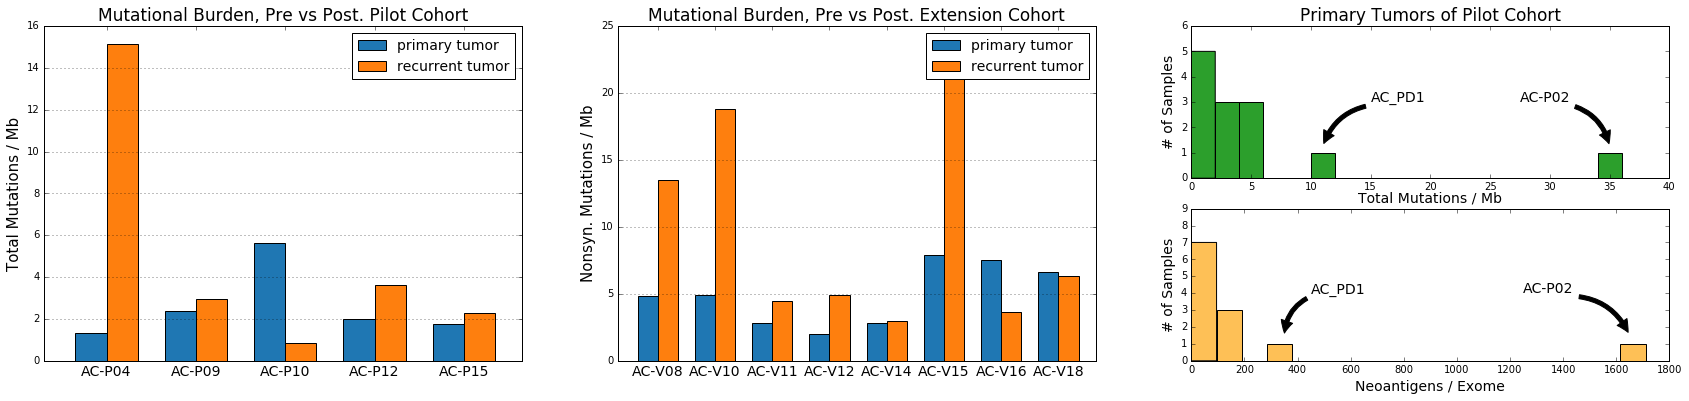

In [20]:
## ========================================
# Create figures
## ========================================
print 'Creating figure 3 ...'

fig = plt.figure(1, figsize = (29.13, 6))
gs = gridspec.GridSpec(2,3)

N = 5
ind = np.arange(N)
width = 0.35
labels = ['AC-P04', 'AC-P09', 'AC-P10', 'AC-P12', 'AC-P15']

# Generate mutational burden plot, pilot cohort
print '...Generating mutational burden plot for pilot cohort...'
ax00 = plt.subplot(gs[:,0])

pre = ax00.bar(ind, df_burden.ix[:, 'Primary load'].tolist(), width, color = colors_fig3[0])
post = ax00.bar(ind + width, df_burden.ix[:, 'Recurrent load'].tolist(), width, color = colors_fig3[1])

plt.xlim(-width, N)

ax00.set_xticks(ind + width)
ax00.set_xticklabels(labels, fontsize = 14)

ax00.legend((pre, post), ('primary tumor', 'recurrent tumor'), fontsize = 14)

ax00.yaxis.grid(True)

# Create annotation for delta purity
deltap_04 = (0.60-0.31)/(0.31) # AC-04, primary = 0.31, recurrent = 0.60
deltap_09 = (0.67-0.63)/(0.63) # AC-09, primary = 0.63, recurrent = 0.67
deltap_10 = (0.20-0.34)/(0.34) # AC-P10, primary = 0.34, recurrent = 0.20
deltap_12 = (0.41-0.34)/(0.34) # AC-P12, primary = 0.34, recurrent = 0.41
deltap_15 = (0.45-0.45)/(0.45) # AC-P15, primary  = 0.45, recurrent = 0.45

delta_p = [deltap_04, deltap_09, deltap_10, deltap_12, deltap_15]
#ax00.text(0.36, 2, r'$\Delta$p=93.5%', ha = 'center', va = 'bottom', fontsize = 13)
#ax00.text(1.36, 3.1, r'$\Delta$p=6.3%', ha = 'center', va = 'bottom', fontsize = 13)
#ax00.text(2.36, 6, r'$\Delta$p=-41.2%', ha = 'center', va = 'bottom', fontsize = 13)
#ax00.text(3.36, 3.7, r'$\Delta$p=20.6%', ha = 'center', va = 'bottom', fontsize = 13)
#ax00.text(4.36, 2.5, r'$\Delta$p=0%', ha = 'center', va = 'bottom', fontsize = 13)

plt.ylabel('Total Mutations / Mb', fontsize = 15)
plt.title('Mutational Burden, Pre vs Post. Pilot Cohort', fontsize = 17)

# Generate extension cohort mutational burden plot
print '...Generating mutational burden plot for extension cohort...'
ax01 = plt.subplot(gs[:,1])

N = 8
ind = np.arange(N)
width = 0.35
labels = ['AC-V08', 'AC-V10', 'AC-V11', 'AC-V12', 'AC-V14', 'AC-V15', 'AC-V16', 'AC-V18']

pre = ax01.bar(ind, pre_mut_extension, width, color = colors_fig3[0])
post = ax01.bar(ind + width, post_mut_extension, width, color = colors_fig3[1])

plt.xlim(-width, N)

ax01.set_xticks(ind + width)
ax01.set_xticklabels(labels, fontsize = 14)

ax01.yaxis.grid(True)

ax01.legend((pre, post), ('primary tumor', 'recurrent tumor'), fontsize = 14)

plt.ylabel('Nonsyn. Mutations / Mb', fontsize = 15)
plt.title('Mutational Burden, Pre vs Post. Extension Cohort', fontsize = 17)

### Generate neoantigen and mutational burden plot
print '...Generating mutational burden and neoantigen plot for pilot cohort primary tumors...'
ax02 = plt.subplot(gs[0,2])

# Plot mutational burden of primary tumors, pilot cohort
hist_pre_mut = ax02.hist(df_pilot_primary_plt.ix['Total', :].tolist(), range(0, 38, 2), facecolor = colors_fig3[3])

ax02.annotate('AC-P02', xy = (35, 1.25), xytext = (27.5, 3), 
              arrowprops=dict(facecolor = 'black', shrink = 0.05, connectionstyle = "arc3, rad = -0.3"), fontsize = 14)
ax02.annotate('AC_PD1', xy = (11, 1.25), xytext = (15, 3), 
              arrowprops=dict(facecolor = 'black', shrink = 0.05, connectionstyle = "arc3, rad = 0.3"), fontsize = 14)

plt.ylim(0,6)

plt.ylabel('# of Samples', fontsize = 14)
plt.xlabel('Total Mutations / Mb', fontsize = 14)
ax02.xaxis.labelpad = -1

plt.title('Primary Tumors of Pilot Cohort', fontsize = 17)

ax12 = plt.subplot(gs[1,2])

# Plot mutational burden of primary tumors, pilot cohort
hist_pre_neo = ax12.hist(pre_neo.tolist(), range(0, 1800, 95), facecolor = colors_fig3[2])

ax12.annotate('AC-P02', xy = (1650, 1.5), xytext = (1250, 4), 
              arrowprops=dict(facecolor = 'black', shrink = 0.05, connectionstyle = "arc3, rad = -0.3"), fontsize = 14)
ax12.annotate('AC_PD1', xy = (350, 1.5), xytext = (450, 4), 
              arrowprops=dict(facecolor = 'black', shrink = 0.05, connectionstyle = "arc3, rad = 0.3"), fontsize = 14)

plt.ylim(0,9)

plt.ylabel('# of Samples', fontsize = 14)
plt.xlabel('Neoantigens / Exome', fontsize = 14)

#plt.show()
plt.savefig('figures/figure3.png', bbox_inches = 'tight')

<a id='supplementary.figure4'></a>
## Supplementary Figure 4: CoMut - No Recurrence vs Recurrence of Primary Tumors
<a href='#table.of.contents'>Return to top</a><br>

In this section, we will produce Supplementary Figure 4 which features a co-mutation plot of primary tumors in the pilot and extension cohorts. Samples that did not recur are shown on the left and those that did recur are shown on the right

In [ ]:
## ========================================================
# Reorder samples and genes by frequency
## ========================================================
# We can begin with the data frames that reordered samples and genes by frequency for each cohort
list_ = list_remove_nan(df_pilot_primary_R_sorted.columns.tolist())
df_pilot_primary_R_sorted_sf4 = df_pilot_primary_R_sorted.ix[:, list_]

list_ = list_remove_nan(df_pilot_primary_NR_sorted.columns.tolist())
df_pilot_primary_NR_sorted_sf4 = df_pilot_primary_NR_sorted.ix[:, list_]

list_ = list_remove_nan(df_ext_primary_R_sorted.columns.tolist())
df_ext_primary_R_sorted_sf4 = df_ext_primary_R_sorted.ix[:, list_]

list_ = list_remove_nan(df_ext_primary_NR_sorted.columns.tolist())
df_ext_primary_NR_sorted_sf4 = df_ext_primary_NR_sorted.ix[:, list_]

# We can concatenate cohorts together by recurrence
# R = Response (No Recurrence), NR = No Response (Recurrence)
df_R = pd.concat([df_pilot_primary_R_sorted_sf4.ix[:,1:], df_ext_primary_R_sorted_sf4.ix[:,1:]], axis = 1)
df_NR = pd.concat([df_pilot_primary_NR_sorted_sf4.ix[:,1:], df_ext_primary_NR_sorted_sf4.ix[:,1:]], axis = 1)

# Like before, I make an aethetic choice of only displaying some genes. The plot is less crowded now so I display more
display_S4 = 15

data_00 = df_R.iloc[:display_S4, :]
data_01 = df_NR.iloc[:display_S4, :]

list_genes = df_pilot_primary_R_sorted_sf4.ix[:,'gene'].tolist()

In [ ]:
## ====================================
# Clinical annotation 1: Cohort status
## ====================================
# This annotation displays whether a sample is in the pilot or extension cohort

resp_cohort = format_cohort(df_pilot_primary_R_sorted_sf4.ix[:,1:], df_ext_primary_R_sorted_sf4.ix[:,1:])
noresp_cohort = format_cohort(df_pilot_primary_NR_sorted_sf4.ix[:,1:], df_ext_primary_NR_sorted_sf4.ix[:,1:])

In [ ]:
## ===============================================
# Clinical annotation 2: All Samples - HPV Status
## ===============================================
resp_hpv_pilot = format_hpv(info_pilot, df_pilot_primary_R_sorted_sf4.ix[:,1:])
resp_hpv_ext = format_hpv(info_extension, df_ext_primary_R_sorted_sf4.ix[:,1:])
noresp_hpv_pilot = format_hpv(info_pilot, df_pilot_primary_NR_sorted_sf4.ix[:,1:])
noresp_hpv_ext = format_hpv(info_extension, df_ext_primary_NR_sorted_sf4.ix[:,1:])

resp_hpv = pd.concat([resp_hpv_pilot, resp_hpv_ext], axis = 1)
noresp_hpv = pd.concat([noresp_hpv_pilot, noresp_hpv_ext], axis = 1)

In [ ]:
## ===============================================
# Genomic annotation 1: All Samples - 3q CNV
## ===============================================
resp_3q_pilot = format_gistic_3q(gistic_pilot_3q, df_pilot_primary_R_sorted_sf4.ix[:,1:])
resp_3q_ext = format_gistic_3q(gistic_ext_3q, df_ext_primary_R_sorted_sf4.ix[:,1:])
noresp_3q_pilot = format_gistic_3q(gistic_pilot_3q, df_pilot_primary_NR_sorted_sf4.ix[:,1:])
noresp_3q_ext = format_gistic_3q(gistic_ext_3q, df_ext_primary_NR_sorted_sf4.ix[:,1:])

resp_3q = pd.concat([resp_3q_pilot, resp_3q_ext], axis = 1)
noresp_3q = pd.concat([noresp_3q_pilot, noresp_3q_ext], axis = 1)

In [ ]:
## ==================================================
# Genomic annotation 2: All Samples - Mutations / MB
## ==================================================

# We calculate the mutations / Mb for all samples illustrated
# For the pilot cohort, MutSig provides mutations / Mb of both total and nonsyn mutations
# For the extension cohort, we calculate an estimate of nonsyn mutational burden

# Pilot Cohort
resp_burden_pilot = format_pilot_load(mutsig_rates, df_pilot_primary_R_sorted_sf4.ix[:,1:])
noresp_burden_pilot = format_pilot_load(mutsig_rates, df_pilot_primary_NR_sorted_sf4.ix[:,1:])

# Extension Cohort
extension_all_calls = pd.read_csv('filter_unmatched/all_genes/df_filter_pass.txt', sep = '\t', low_memory = False)

resp_burden_ext = format_extension_load(info_extension, extension_all_calls, df_ext_primary_R_sorted_sf4.ix[:,1:])
noresp_burden_ext = format_extension_load(info_extension, extension_all_calls, df_ext_primary_NR_sorted_sf4.ix[:,1:])

resp_burden = pd.concat([resp_burden_pilot, resp_burden_ext], axis = 1)
noresp_burden = pd.concat([noresp_burden_pilot, noresp_burden_ext], axis = 1)

In [ ]:
## ===========================================================
# Supplementary Figure 4: CoMut of Primary / Recurrent Tumors
## ===========================================================

fig = plt.figure(figsize = (22,16))
gs = gridspec.GridSpec(5, 3, height_ratios = [1, 1, 2*display_S4, 1, display_S4/2], 
                      width_ratios = [len(data_00), len(data_01), len(data_00)/4])
gs.update(wspace = 0.08, hspace = 0.04)

##============================================
# ax20 - CoMut - Response Primary Samples
##============================================
ax20, cax20 = plot_comut(2, 0, data_00, list_genes, 1, 'italic', cmap_fig1_comut, norm_fig1_comut, 'white')

##============================================
# ax21 - CoMut - No Response Primary Samples
##============================================
ax21, cax21 = plot_comut(2, 1, data_01, list_genes, 0, 'normal', cmap_fig1_comut, norm_fig1_comut, 'white')

##============================================
# ax00 - Cohort Status - Response Primary Samples
##============================================
ax00, cax00 = plot_comut(0, 0, resp_cohort, resp_cohort.index.tolist(), 1, 'normal', 
                         cmap_cohort, norm_cohort, 'black', sharex = ax20)

plt.title('No Recurrence', y = 1.15, fontsize = 24)

##============================================
# ax01 - Cohort Status - No Response Primary Samples
##============================================
ax01, cax01 = plot_comut(0, 1, noresp_cohort, noresp_cohort.index.tolist(), 0, 'normal', 
                         cmap_cohort, norm_cohort, 'black', sharex = ax21, sharey = ax00)

plt.title('Recurrence', y = 1.15, fontsize = 24)

##============================================
# ax10 - Hpv Status - Response Primary Samples
##============================================
ax10, cax10 = plot_comut(1, 0, resp_hpv, resp_hpv.index.tolist(), 1, 'normal', 
                         cmapHPV, normHPV, 'black', sharex = ax20)

##============================================
# ax11 - Hpv Status - No Response Primary Samples
##============================================
ax11, cax11 = plot_comut(1, 1, noresp_hpv, resp_hpv.index.tolist(), 0, 'normal', 
                         cmapHPV, normHPV, 'black', sharex = ax21, sharey = ax10)

##============================================
# ax30 - 3q Status - Response Primary Samples
##============================================
ax30, cax30 = plot_comut(3, 0, resp_3q, resp_3q.index.tolist(), 1, 'normal', 
                         cmap3q, norm3q, 'black', sharex = ax20)

##============================================
# ax31 - 3q Status - No Response Primary Samples
##============================================
ax31, cax31 = plot_comut(3, 1, noresp_3q, noresp_3q.index.tolist(), 0, 'normal', 
                         cmap3q, norm3q, 'black', sharex = ax20, sharey = ax30)

##==============================================
# ax40 - Mutations / Mb - Response Primary Samples
##==============================================
ax40 = plot_burden(4, 0, resp_burden, 1, colors_bar, 10, 40, 
                                      display_label = 'Mutations / Mb', sharex = ax20)

##==============================================
# ax41 - Mutations / Mb - No Response Primary Samples
##==============================================
ax41 = plot_burden(4, 1, noresp_burden, 0, colors_bar, 10, 40,
                                     sharex = ax21, sharey = ax40)

##============================================
# ax02 - Legend - Cohort Status
##============================================
labels = ['Pilot', 'Extension']
ax02 = create_legend(0, 2, labels, colors_cohort, 1.65, 1.4, 2)

##============================================
# ax12 - Legend - HPV Status
##============================================
labels = [' Neg ', 'Positive']
ax12 = create_legend(1, 2, labels, colors_tableauHPV, 1.6, 1.4, 2)

##============================================
# ax22 - Legend - Mutation Type
##============================================
ax22 = plt.subplot(gs[2,2])

# Remove plot frame lines
ax22.spines['top'].set_visible(False)
ax22.spines['bottom'].set_visible(False)
ax22.spines['right'].set_visible(False)
ax22.spines['left'].set_visible(False)

plt.tick_params(axis = 'both', which = 'both', 
    bottom = 'off', top = 'off', left = 'off', right = 'off',
    labelbottom = 'off', labelleft = 'off', labelright = 'off')

labels = ["Syn.", "Missense", "Nonsense", "Inframe indel"]

ax22.bar(0, 0, label = labels[0], color = colors_fig1_comut[1]) # Syn
ax22.bar(1, 0, label = labels[1], color = colors_fig1_comut[2]) # Missense
ax22.bar(2, 0, label = labels[2], color = colors_fig1_comut[4]) # Nonsense
ax22.bar(4, 0, label = labels[3], color = colors_fig1_comut[6]) # Inframe Indel

plt.ylim(0)

legend = ax22.legend(bbox_to_anchor = (1.15, 1), ncol = 1, handlelength = 3, fontsize = 14, columnspacing = 1, 
               frameon = False)
legend.get_title().set_fontsize('14')

##============================================
# ax32 - Legend - 3q CNV status
##============================================
#labels = ["Loss", "Gain"]
#ax32 = create_legend(3, 2, labels, colors_tableau3q, 1.0, 1.0, 2)
ax32 = plt.subplot(gs[3,2])

# Remove plot frame lines
ax32.spines['top'].set_visible(False)
ax32.spines['bottom'].set_visible(False)
ax32.spines['right'].set_visible(False)
ax32.spines['left'].set_visible(False)

plt.tick_params(axis = 'both', which = 'both', 
    bottom = 'off', top = 'off', left = 'off', right = 'off',
    labelbottom = 'off', labelleft = 'off', labelright = 'off')

labels = ["Loss", "Gain"]

ax32.bar(0, 0, label = labels[0], color = colors_tableau3q[1]) # Loss
ax32.bar(1, 0, label = labels[1], color = colors_tableau3q[3]) # Gain

plt.ylim(0)

legend = ax32.legend(bbox_to_anchor = (1.4, 1.25), ncol = 2, handlelength = 3, fontsize = 14, columnspacing = 1, 
               frameon = False)
legend.get_title().set_fontsize('14')

##============================================
# ax42 - Legend - Mutational Burden
##============================================
labels = ["Non Syn", "Syn"]
ax42 = create_legend(4, 2, labels, colors_bar, 1.52, 1.0, 2)

plt.savefig('figures/figureS4.png', bbox_inches = 'tight')
#plt.show()

<a id='supplementary.figure6a'></a>
## Supplementary Figure 6a: CoMut - Primary and Recurrent Pairs
<a href='#table.of.contents'>Return to top</a><br>

In this section, we will produce Supplementary Figure 6a which features a co-mutation plot of primary and recurrent tumor pairs in the pilot and extension cohorts. Primary and recurrent pairs are shown for the pilot cohort on the left and the extension cohort on the right

In [ ]:
## ========================================================
# Generate dataframes
## ========================================================

# We create our lists of samples for each cohort
pilot_list = ['AC-P04-Tumor-SM-63B4O','AC-P04-Tumor-SM-63B4Q','AC-P09-Tumor-SM-63B4Z',
              'AC-P09-Tumor-SM-63B52','AC-P10-Tumor-SM-63B53','AC-P10-Tumor-SM-63B55',
              'AC-P12-Tumor-SM-63B58','AC-P12-Tumor-SM-63B59','AC-P15-Tumor-SM-63B5D',
              'AC-P15-Tumor-SM-63B5F']

extension_list = ['AC-V08-Tumor-SM-9J45Z','AC-V08-Tumor-SM-9J461','AC-V08-Tumor-SM-9J462',
                  'AC-V09-Tumor-SM-9J463','AC-V09-Tumor-SM-9J464','AC-V10-Tumor-SM-9J465',
                  'AC-V10-Tumor-SM-9J466','AC-V11-Tumor-SM-9J467','AC-V11-Tumor-SM-9J468',
                  'AC-V12-Tumor-SM-9N4BH','AC-V12-Tumor-SM-9J46A','AC-V14-Tumor-SM-9J46C',
                  'AC-V14-Tumor-SM-9J46D','AC-V15-Tumor-SM-9J46E','AC-V15-Tumor-SM-9J46F',
                  'AC-V16-Tumor-SM-9J46G','AC-V16-Tumor-SM-9J46H','AC-V18-Tumor-SM-9J46J',
                  'AC-V18-Tumor-SM-9J46K']

df_pilot_pairs = populate(pilot_list, df_genes, variants_pilot)
df_extension_pairs = populate(extension_list, df_genes, variants_extension)

# Sort vertically by frequency
df_freq_pilot_pairs = df_pilot_pairs.replace(0, np.nan)
df_freq_extension_pairs = df_extension_pairs.replace(0, np.nan)

freq_pairs = (df_freq_pilot_pairs.count(axis = 1, numeric_only = True) + \
             df_freq_extension_pairs.count(axis = 1, numeric_only = True))

freq_pairs.sort_values(ascending = False, inplace = True)

# We sort our dataframes across genes depending on frequency across both cohorts
df_pilot_pairs_sorted = pd.DataFrame(df_pilot_pairs, index = freq_pairs.index)
df_extension_pairs_sorted = pd.DataFrame(df_extension_pairs, index = freq_pairs.index)

df_pilot_pairs_sorted.index = range(0, len(df_pilot_pairs_sorted))
df_extension_pairs_sorted.index = range(0, len(df_extension_pairs_sorted))

In [ ]:
# Like before, I make an aethetic choice of only displaying some genes. The plot is less crowded now so I display more
display_S6A = 18

data_00 = df_pilot_pairs_sorted.iloc[:display_S6A, 1:]
data_01 = df_extension_pairs_sorted.iloc[:display_S6A, 1:]

list_genes = df_pilot_pairs_sorted.ix[:,'gene'].tolist()

In [ ]:
## ===============================================
# Clinical annotation 1: All Samples - HPV Status
## ===============================================
hpv_pilot = format_hpv(info_pilot, df_pilot_pairs_sorted.ix[:,1:])
hpv_extension = format_hpv(info_extension, df_extension_pairs_sorted.ix[:,1:])

In [ ]:
## ===============================================
# Genomic annotation 1: All Samples - 3q CNV
## ===============================================
gistic_pilot_pairs = format_gistic_3q(gistic_pilot_3q, df_pilot_pairs_sorted.ix[:,1:])
gistic_extension_pairs = format_gistic_3q(gistic_ext_3q, df_extension_pairs_sorted.ix[:,1:])

In [ ]:
## ==================================================
# Genomic annotation 2: All Samples - Mutations / MB
## ==================================================
burden_pilot_pairs = format_pilot_load(mutsig_rates, df_pilot_pairs_sorted.ix[:,1:])
burden_extension_pairs = format_extension_load(info_extension, extension_all_calls, df_extension_pairs_sorted.ix[:,1:])

In [ ]:
## ===========================================================
# Supplementary Figure 4: CoMut of Primary / Recurrent Tumors
## ===========================================================
fig = plt.figure(figsize = (22,16))
gs = gridspec.GridSpec(4, 3, height_ratios = [1, 2*display_S6A, 1, display_S6A/2], 
                      width_ratios = [len(data_00), len(data_01), len(data_00)/4])
gs.update(wspace = 0.08, hspace = 0.04)

##============================================
# ax10 - CoMut - Response Primary Samples
##============================================
ax10, cax10 = plot_comut(1, 0, data_00, list_genes, 1, 'italic', cmap_fig1_comut, norm_fig1_comut, 'white')

divider = [2,4,6,8,10]
for i in range(0,len(divider)-1,1):
    ax10.plot((divider[i] - 0.5, divider[i] - 0.5),(-0.5, display_S6A - 0.5),'k-', linewidth=2.0)    

##============================================
# ax11 - CoMut - No Response Primary Samples
##============================================
ax11, cax11 = plot_comut(1, 1, data_01, list_genes, 0, 'normal', cmap_fig1_comut, norm_fig1_comut, 'white')

divider = [3,5,7,9,11,13,15,17]
for i in range(0,len(divider)-1,1):
    ax11.plot((divider[i] - 0.5, divider[i] - 0.5),(-0.50, display_S6A - 0.51),'k-', linewidth=2.0)

##============================================
# ax00 - Hpv Status - Response Primary Samples
##============================================
ax00, cax00 = plot_comut(0, 0, hpv_pilot, hpv_pilot.index.tolist(), 1, 'normal', 
                         cmapHPV, normHPV, 'black', sharex = ax10)

plt.title('Pilot Cohort', y = 1.05, fontsize = 20)

##============================================
# ax01 - Hpv Status - No Response Primary Samples
##============================================
ax01, cax01 = plot_comut(0, 1, hpv_extension, hpv_extension.index.tolist(), 0, 'normal', 
                         cmapHPV, normHPV, 'black', sharex = ax11, sharey = ax00)

plt.title('Extension Cohort', y = 1.05, fontsize = 20)

##============================================
# ax20 - 3q Status - Response Primary Samples
##============================================
ax20, cax20 = plot_comut(2, 0, gistic_pilot_pairs, gistic_pilot_pairs.index.tolist(), 1, 'normal', 
                         cmap3q, norm3q, 'black', sharex = ax10)

##============================================
# ax21 - 3q Status - No Response Primary Samples
##============================================
ax21, cax21 = plot_comut(2, 1, gistic_extension_pairs, gistic_extension_pairs.index.tolist(), 0, 'normal', 
                         cmap3q, norm3q, 'black', sharex = ax11, sharey = ax20)

##==============================================
# ax30 - Mutations / Mb - Response Primary Samples
##==============================================
ax30 = plot_burden(3, 0, burden_pilot_pairs, 1, colors_bar, 10, 25, 
                                      display_label = 'Mutations / Mb', sharex = ax10)

##==============================================
# ax31 - Mutations / Mb - No Response Primary Samples
##==============================================
ax31 = plot_burden(3, 1, burden_extension_pairs, 0, colors_bar, 10, 25,
                                     sharex = ax11, sharey = ax30)

##============================================
# ax12 - Legend - Mutation Type
##============================================
ax12 = plt.subplot(gs[1,2])

# Remove plot frame lines
ax12.spines['top'].set_visible(False)
ax12.spines['bottom'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.spines['left'].set_visible(False)

plt.tick_params(axis = 'both', which = 'both', 
    bottom = 'off', top = 'off', left = 'off', right = 'off',
    labelbottom = 'off', labelleft = 'off', labelright = 'off')

labels = ["Synonymous", "Missense", "Splice Site", "Nonsense", "Frameshift", "InDel"]

ax12.bar(1, 0, label = labels[1], color = colors_fig1_comut[2]) # Missense
ax12.bar(4, 0, label = labels[3], color = colors_fig1_comut[4]) # Nonsense
ax12.bar(4, 0, label = labels[5], color = colors_fig1_comut[6]) # Indel

plt.ylim(0)

legend = ax12.legend(bbox_to_anchor = (0.9, 0.90), ncol = 1, handlelength = 3, fontsize = 14, columnspacing = 1, 
               frameon = False)

##============================================
# ax02 - Legend - HPV Status
##============================================
labels = [' Neg ', 'Positive', 'Unknown']
ax02 = create_legend(0, 2, labels, colors_tableauHPV, 1.75, 1.75, 2)

##============================================
# ax22 - Legend - 3q CNV status
##============================================
labels = ["Loss", "Gain"]
ax22 = plt.subplot(gs[2,2])

# Remove plot frame lines
ax22.spines['top'].set_visible(False)
ax22.spines['bottom'].set_visible(False)
ax22.spines['right'].set_visible(False)
ax22.spines['left'].set_visible(False)

plt.tick_params(axis = 'both', which = 'both', 
    bottom = 'off', top = 'off', left = 'off', right = 'off',
    labelbottom = 'off', labelleft = 'off', labelright = 'off')

ax22.bar(0, 0, label = labels[0], color = colors_tableau3q[1]) # Loss
ax22.bar(1, 0, label = labels[1], color = colors_tableau3q[2]) # Gain

plt.ylim(0)

legend = ax22.legend(bbox_to_anchor = (1.42, 1.70), ncol = 2, handlelength = 3, fontsize = 14, columnspacing = 1, 
               frameon = False)

##============================================
# ax32 - Legend - Mutational Burden
##============================================
labels = ["Nonsyn burden", "Syn burden"]
ax32 = create_legend(3, 2, labels, colors_bar, 1.25, 1.0, 1)


plt.savefig('figures/figureS6A.png', bbox_inches = 'tight')
#plt.show()

## Calculations

<a id='methods.tumoronly.filter'></a>
## Methods: Applying tumor only filter to the pilot cohort
<a href='#table.of.contents'>Return to top</a><br>

For validation and metric purposes, we applied the tumor only filter to the pilot cohort's unmatched tumor pairs to the matched tumor pairs

In [ ]:
# We import our golden standard, the matched tumor samples
allfiles = glob.glob('storage/mafs/pilot_snv/*')
df_master_ = pd.DataFrame()
list_ = []

for file_ in allfiles:
    df_ = pd.read_csv(file_, index_col = None, sep = '\t', 
                     comment = '#', low_memory = False)
    list_.append(df_)
df_master_ = pd.concat(list_, ignore_index = True)  

# To compare apples to apples, we shrink the reference to only Missense, Nonsense, and Splice site mutations
df_master = df_master_[df_master_['Variant_Classification'].isin(['Missense_Mutation', 'Nonsense_Mutation', 'Splice_Site'])]
df_master.index = range(0, len(df_master))

# We import the comparison, the unmatched tumor samples post-filtering
df_passed = pd.read_csv('filter_unmatched/pilot_all_genes/df_filter_pass.txt', sep = '\t', 
                       comment = '#', low_memory = False)
df_failed = pd.read_csv('filter_unmatched/pilot_all_genes/df_filter_failed.txt', sep = '\t', 
                       comment = '#', low_memory = False)

print 'We see a', str(format(round((len(df_passed) + len(df_failed))/len(df_master)*100,2))), '% increase in mutation calls in the pilot cohort when considering unmatched vs matched tumor samples, after upstream filtering was performed (such as PoN and FFPE filters)'
print 'Specifically, we observe', str(len(df_passed) + len(df_failed)), 'variants being called in the tumor only case and', str(len(df_master)), 'for matched pairs.'
print ''
print 'After applying our novel tumor only filtering on the unmatched samples, this number shrinks.'
print str(len(df_passed)), 'variants passed our filter and', str(len(df_failed)), 'failed.'

In [ ]:
# For some reason that I could not discover, the start_position column of the passed dataframe was being processed as a float
# so we convert it to an integer
df_passed.ix[:, 'Start_position'] = df_passed.ix[:,'Start_position'].astype(int)

In [ ]:
## For all genes
# For quick processing of comparison, we combine identifying columns into one series

id_master = df_master['Chromosome'].map(str) + df_master['Start_position'].map(str) + df_master['Tumor_Sample_Barcode'] + \
    df_master['Reference_Allele'] + df_master['Tumor_Seq_Allele1'] + df_master['Tumor_Seq_Allele2']
id_passed = df_passed['Chromosome'].map(str) + df_passed['Start_position'].fillna(0.0).map(str) + df_passed['Tumor_Sample_Barcode'] + \
    df_passed['Reference_Allele'] + df_passed['Tumor_Seq_Allele1'] + df_passed['Tumor_Seq_Allele2']
id_failed = df_failed['Chromosome'].map(str) + df_failed['Start_position'].fillna(0.0).map(str) + df_failed['Tumor_Sample_Barcode'] + \
    df_failed['Reference_Allele'] + df_failed['Tumor_Seq_Allele1'] + df_failed['Tumor_Seq_Allele2'] 
    
# Calculate True Positives, False Positives, False Negatives, TrueNegatives
idx_tp = (id_master).isin(id_passed)
TruePositive = len(df_master[idx_tp])         # Correctly called, post-filtering
idx_tn = (id_master).isin(id_failed)
TrueNegative = len(df_master[~idx_tn])        # Correctly filtered, post-filtering

idx_fp = (id_passed).isin(id_master)
FalsePositive = len(df_passed[~idx_fp])       # Incorrectly called, post-filtering
idx_fn = (id_failed).isin(id_master)
FalseNegative = len(df_failed[idx_fn])        # Incorrectly filtered, post-filtering

# Calculate PPV and Sensitivity
PPV = TruePositive / (TruePositive + FalsePositive)
Sensitivity = TruePositive / (TruePositive + FalseNegative)

print 'Our filtering approach yields the following results when applied to the pilot cohort, when considering all genes:'
print 'PPV:', str(PPV)
print 'Sensitivity:', str(Sensitivity)

In [ ]:
## For 268 genes
genes_tcga = pd.read_csv('storage/reference/tcga_genes.txt', sep = '\t')

df_master = df_master[df_master['Hugo_Symbol'].isin(genes_tcga['gene'])]
df_passed = df_passed[df_passed['Hugo_Symbol'].isin(genes_tcga['gene'])]
df_failed = df_failed[df_failed['Hugo_Symbol'].isin(genes_tcga['gene'])]

# For quick processing of comparison, we combine identifying columns into one series

id_master = df_master['Chromosome'].map(str) + df_master['Start_position'].map(str) + df_master['Tumor_Sample_Barcode'] + \
    df_master['Reference_Allele'] + df_master['Tumor_Seq_Allele1'] + df_master['Tumor_Seq_Allele2']
id_passed = df_passed['Chromosome'].map(str) + df_passed['Start_position'].fillna(0.0).map(str) + df_passed['Tumor_Sample_Barcode'] + \
    df_passed['Reference_Allele'] + df_passed['Tumor_Seq_Allele1'] + df_passed['Tumor_Seq_Allele2']
id_failed = df_failed['Chromosome'].map(str) + df_failed['Start_position'].fillna(0.0).map(str) + df_failed['Tumor_Sample_Barcode'] + \
    df_failed['Reference_Allele'] + df_failed['Tumor_Seq_Allele1'] + df_failed['Tumor_Seq_Allele2'] 
    
# Calculate True Positives, False Positives, False Negatives, TrueNegatives
idx_tp = (id_master).isin(id_passed)
TruePositive = len(df_master[idx_tp])         # Correctly called, post-filtering
idx_tn = (id_master).isin(id_failed)
TrueNegative = len(df_master[~idx_tn])        # Correctly filtered, post-filtering

idx_fp = (id_passed).isin(id_master)
FalsePositive = len(df_passed[~idx_fp])       # Incorrectly called, post-filtering
idx_fn = (id_failed).isin(id_master)
FalseNegative = len(df_failed[idx_fn])        # Incorrectly filtered, post-filtering

# Calculate PPV and Sensitivity
PPV = TruePositive / (TruePositive + FalsePositive)
Sensitivity = TruePositive / (TruePositive + FalseNegative)

print 'Our filtering approach yields the following results when applied to the pilot cohort, when considering a genes reported in TCGA(n=268):'
print 'PPV:', str(PPV)
print 'Sensitivity:', str(Sensitivity)
print '* TCGA genes obtained from tumorportal.org'

<a id='results.primary.ascc'></a>
## Results: Genomic Landscape of Primary ASCC
<a href='#table.of.contents'>Return to top</a><br>

We will replicate any calculations cited in this section of the paper, this primarily contains reports from MutSig for the pilot cohort.

In [ ]:
input_info_pilot = r'storage/reference/ASCC_samples-pilot.txt'
info_pilot = pd.read_csv(input_info_pilot, sep = '\t')

list_pilot_primary = info_pilot[info_pilot['Tumor Type'] == 'Primary'].ix[:,'Tumor Sample ID'].tolist()
list_pilot_recurrent = info_pilot[info_pilot['Tumor Type'] != 'Primary'].ix[:,'Tumor Sample ID'].tolist()

In [ ]:
## MutSig breakdown for the pilot cohort (both primary and recurrent tumors)
# Just in case this section is run independently, we re-import MutSig results
df_pilot = pd.read_csv('storage/mutsig-pilot/final_analysis_set.maf', sep = '\t',
                      comment = '#', low_memory = False)

pilot_missense = df_pilot[df_pilot['Variant_Classification'] == 'Missense_Mutation']
pilot_nonsense = df_pilot[df_pilot['Variant_Classification'] == 'Nonsense_Mutation']
pilot_frameshift = df_pilot[df_pilot['Variant_Classification'].isin(['Frame_Shift_Del', 'Frame_Shift_Ins'])]
pilot_silent = df_pilot[df_pilot['Variant_Classification'] == 'Silent']

print 'A total of', str(len(df_pilot)), 'somatic mutations were found after running MutSig on the pilot cohort, this include:'
print str(len(pilot_missense)), 'missense mutations'
print str(len(pilot_nonsense)), 'nonsense mutations'
print str(len(pilot_frameshift)), 'frameshift mutations'
print str(len(pilot_silent)), 'silent mutations \n'

print 'These values reflect mutations reported for both primary and recurrent samples'

In [ ]:
## Mutational burden for the pilot cohort (Repeat calculations from Figure 3)
mutsig_burden = pd.read_csv('storage/mutsig-pilot/patient_counts_and_rates.txt', sep = '\t')

pilot_burden_mean = mutsig_burden.ix[:,'rate_tot'].mean()
pilot_burden_mean = pilot_burden_mean*10*10*10*10*10*10 # Convert from per base to per Mb

pilot_burden_min = mutsig_burden.ix[:,'rate_tot'].min()
pilot_burden_min = pilot_burden_min*10*10*10*10*10*10 # Convert from per base to per Mb

pilot_burden_max = mutsig_burden.ix[:,'rate_tot'].max()
pilot_burden_max = pilot_burden_max*10*10*10*10*10*10 # Convert from per base to per Mb

print 'The mean somatic rate for the pilot cohort was', str(pilot_burden_mean)
print 'with a range of', str(pilot_burden_min), 'to', str(pilot_burden_max), 'mutations per Mb'

In [ ]:
# We repeat the calculation for only primary samples
## MutSig breakdown for the pilot cohort (both primary and recurrent tumors)
# Just in case this section is run independently, we re-import MutSig results
df_pilot = pd.read_csv('storage/mutsig-pilot/final_analysis_set.maf', sep = '\t',
                      comment = '#', low_memory = False)

df_pilot_primary = df_pilot[df_pilot['Tumor_Sample_Barcode'].isin(list_pilot_primary)]

pilot_missense_primary = df_pilot_primary[df_pilot_primary['Variant_Classification'] == 'Missense_Mutation']
pilot_nonsense_primary = df_pilot_primary[df_pilot_primary['Variant_Classification'] == 'Nonsense_Mutation']
pilot_frameshift_primary = df_pilot_primary[df_pilot_primary['Variant_Classification'].isin(['Frame_Shift_Del', 'Frame_Shift_Ins'])]
pilot_silent_primary = df_pilot_primary[df_pilot_primary['Variant_Classification'] == 'Silent']

print 'A total of', str(len(df_pilot_primary)), 'somatic mutations were found after running MutSig on the pilot cohort primary samples, this include:'
print str(len(pilot_missense_primary)), 'missense mutations'
print str(len(pilot_nonsense_primary)), 'nonsense mutations'
print str(len(pilot_frameshift_primary)), 'frameshift mutations'
print str(len(pilot_silent_primary)), 'silent mutations \n'

## Mutational burden for the pilot cohort (Repeat calculations from Figure 3)
mutsig_burden_primary = mutsig_burden[mutsig_burden['name'].isin(list_pilot_primary)]

pilot_burden_mean_primary = mutsig_burden_primary.ix[:,'rate_tot'].mean()
pilot_burden_mean_primary = pilot_burden_mean_primary*10*10*10*10*10*10 # Convert from per base to per Mb

pilot_burden_min_primary = mutsig_burden_primary.ix[:,'rate_tot'].min()
pilot_burden_min_primary = pilot_burden_min_primary*10*10*10*10*10*10 # Convert from per base to per Mb

pilot_burden_max_primary = mutsig_burden_primary.ix[:,'rate_tot'].max()
pilot_burden_max_primary = pilot_burden_max_primary*10*10*10*10*10*10 # Convert from per base to per Mb

print 'The mean somatic rate for the pilot cohort was', str(pilot_burden_mean_primary)
print 'with a range of', str(pilot_burden_min_primary), 'to', str(pilot_burden_max_primary), 'mutations per Mb'

print 'These values reflect mutations reported for primary samples'

In [ ]:
# We repeat the calculation for only primary samples
## MutSig breakdown for the pilot cohort (both primary and recurrent tumors)
# Just in case this section is run independently, we re-import MutSig results
df_pilot = pd.read_csv('storage/mutsig-pilot/final_analysis_set.maf', sep = '\t',
                      comment = '#', low_memory = False)

df_pilot_recurrent = df_pilot[df_pilot['Tumor_Sample_Barcode'].isin(list_pilot_recurrent)]

pilot_missense_recurrent = df_pilot_recurrent[df_pilot_recurrent['Variant_Classification'] == 'Missense_Mutation']
pilot_nonsense_recurrent = df_pilot_recurrent[df_pilot_recurrent['Variant_Classification'] == 'Nonsense_Mutation']
pilot_frameshift_recurrent = df_pilot_recurrent[df_pilot_recurrent['Variant_Classification'].isin(['Frame_Shift_Del', 'Frame_Shift_Ins'])]
pilot_silent_recurrent = df_pilot_recurrent[df_pilot_recurrent['Variant_Classification'] == 'Silent']

print 'A total of', str(len(df_pilot_recurrent)), 'somatic mutations were found after running MutSig on the pilot cohort recurrent samples, this include:'
print str(len(pilot_missense_recurrent)), 'missense mutations'
print str(len(pilot_nonsense_recurrent)), 'nonsense mutations'
print str(len(pilot_frameshift_recurrent)), 'frameshift mutations'
print str(len(pilot_silent_recurrent)), 'silent mutations \n'

## Mutational burden for the pilot cohort (Repeat calculations from Figure 3)
mutsig_burden_recurrent = mutsig_burden[mutsig_burden['name'].isin(list_pilot_recurrent)]

pilot_burden_mean_recurrent = mutsig_burden_recurrent.ix[:,'rate_tot'].mean()
pilot_burden_mean_recurrent = pilot_burden_mean_recurrent*10*10*10*10*10*10 # Convert from per base to per Mb

pilot_burden_min_recurrent = mutsig_burden_recurrent.ix[:,'rate_tot'].min()
pilot_burden_min_recurrent = pilot_burden_min_recurrent*10*10*10*10*10*10 # Convert from per base to per Mb

pilot_burden_max_recurrent = mutsig_burden_recurrent.ix[:,'rate_tot'].max()
pilot_burden_max_recurrent = pilot_burden_max_recurrent*10*10*10*10*10*10 # Convert from per base to per Mb

print 'The mean somatic rate for the pilot cohort was', str(pilot_burden_mean_recurrent)
print 'with a range of', str(pilot_burden_min_recurrent), 'to', str(pilot_burden_max_recurrent), 'mutations per Mb'

print 'These values reflect mutations reported for recurrent samples'

<a id='results.recurrent.ascc'></a>
## Results: Genomic Landscape of Recurrent ASCC
<a href='#table.of.contents'>Return to top</a><br>

We will replicate any calculations cited in this section of the paper, this primarily contains calculations that were performed for figure 1. We calculate the mutational burden for all primary and recurrent samples and then compare them with paired t-tests using the Python package scipy, we do not assume equal variance.

In [ ]:
# First and foremost, we import some files that contain annotations
input_info_pilot = r'storage/reference/ASCC_samples-pilot.txt'
info_pilot = pd.read_csv(input_info_pilot, sep = '\t')

input_info_extension = r'storage/reference/ASCC_samples-extension.txt'
info_extension = pd.read_csv(input_info_extension, sep = '\t')

# Create lists of primary and recurrent tumors from each cohort
list_pilot_primary = info_pilot[info_pilot['Tumor Type'] == 'Primary'].ix[:,'Tumor Sample ID'].tolist()
list_pilot_recurrent = info_pilot[info_pilot['Tumor Type'] != 'Primary'].ix[:,'Tumor Sample ID'].tolist()

list_extension_primary = info_extension[info_extension['Tumor Type'] == 'Primary'].ix[:,'Tumor Sample ID'].tolist()
list_extension_recurrent = info_extension[info_extension['Tumor Type'] != 'Primary'].ix[:,'Tumor Sample ID'].tolist()

In [ ]:
# Because of how I wrote the functions "format_pilot_load" and "format_extension_load", 
# I will move the lists created above into dataframes
df_list_pilot_primary = pd.DataFrame([], columns = list_pilot_primary)
df_list_pilot_recurrent = pd.DataFrame([], columns = list_pilot_recurrent)

df_list_extension_primary = pd.DataFrame([], columns = list_extension_primary)
df_list_extension_recurrent = pd.DataFrame([], columns = list_extension_recurrent)

# Import files necessary to compute mutational burden
pilot_mutsig_rates = pd.read_csv('storage/mutsig-pilot/patient_counts_and_rates.txt', sep = '\t')
extension_all_calls = pd.read_csv('filter_unmatched/all_genes/df_filter_pass.txt', sep = '\t', low_memory = False) 

In [ ]:
# Compute mutational burden
# This is very similar to the calculatiosn done in Figure 1 and Figure 3 but we are now performing 
# the calculation for all samples, rather than just the ones required for those figures

df_pilot_primary = format_pilot_load(pilot_mutsig_rates, df_list_pilot_primary)
df_pilot_recurrent = format_pilot_load(pilot_mutsig_rates, df_list_pilot_recurrent)

df_extension_primary = format_extension_load(info_extension, extension_all_calls, df_list_extension_primary)
df_extension_recurrent = format_extension_load(info_extension, extension_all_calls, df_list_extension_recurrent)

In [ ]:
# We now perform some comparison calculations using the package scipy for paired t-tests
# We do not assume equal variance

print 'We compare the mutational burden in the pilot cohort \n'

statistic, pvalue = stats.ttest_ind(df_pilot_primary.ix['Total', :], df_pilot_recurrent.ix['Total', :], equal_var = False )
print 'Total mutational burden:', str(statistic), str(pvalue)
statistic, pvalue = stats.ttest_ind(df_pilot_primary.ix['Nonsyn', :], df_pilot_recurrent.ix['Nonsyn', :], equal_var = False )
print 'Nonsyn mutational burden:', str(statistic), str(pvalue)
statistic, pvalue = stats.ttest_ind(df_pilot_primary.ix['Syn', :], df_pilot_recurrent.ix['Syn', :], equal_var = False )
print 'Syn mutational burden:', str(statistic), str(pvalue)

print '\n'

print 'We compare the mutational burden in the extension cohort \n'

statistic, pvalue = stats.ttest_ind(df_extension_primary.ix['Nonsyn', :], df_extension_recurrent.ix['Nonsyn', :], equal_var = False )
print 'Nonsyn mutational burden:', str(statistic), str(pvalue)

In [ ]:
## We have estimated the mutational burden for the unmatched samples by estimating the 
# nonsyn mutational burden. We compare the extension cohort's estimated burden
# to both the pilot cohort's total mutational burden and nonsyn burden

print 'We compare the mutational burden across the extension cohort to the pilot cohort \n'
print 'For primary tumors...'

statistic, pvalue = stats.ttest_ind(df_pilot_primary.ix['Total', :], df_extension_primary.ix['Nonsyn', :], equal_var = False)
print 'Total burden of the pilot cohort:', str(statistic), str(pvalue)
statistic, pvalue = stats.ttest_ind(df_pilot_primary.ix['Nonsyn', :], df_extension_primary.ix['Nonsyn', :], equal_var = False)
print 'Nonsyn burden of the pilot cohort:', str(statistic), str(pvalue)

print ''

print 'For recurrent tumors...'
statistic, pvalue = stats.ttest_ind(df_pilot_recurrent.ix['Total', :], df_extension_recurrent.ix['Nonsyn', :], equal_var = False)
print 'Total burden of the pilot cohort:', str(statistic), str(pvalue)
statistic, pvalue = stats.ttest_ind(df_pilot_recurrent.ix['Nonsyn', :], df_extension_recurrent.ix['Nonsyn', :], equal_var = False)
print 'Nonsyn burden of the pilot cohort:', str(statistic), str(pvalue)

In [ ]:
## We now combine populations of primary and recurrent tumors together between the pilot
# and extension cohort

# We combine the total burden of the primary cohort with nonsyn burden of the extension cohort
total_primary = df_pilot_primary.ix['Total', :].tolist() + df_extension_primary.ix['Nonsyn', :].tolist()
total_recurrent = df_pilot_recurrent.ix['Total', :].tolist() + df_extension_recurrent.ix['Nonsyn', :].tolist()

# We combine the total burden of the primary cohort with nonsyn burden of the extension cohort
nonsyn_primary = df_pilot_primary.ix['Nonsyn', :].tolist() + df_extension_primary.ix['Nonsyn', :].tolist()
nonsyn_recurrent = df_pilot_recurrent.ix['Nonsyn', :].tolist() + df_extension_recurrent.ix['Nonsyn', :].tolist()

print 'We compare the mutational burden of primary and recurrent tumors across both cohorts \n'

statistic, pvalue = stats.ttest_ind(total_primary, total_recurrent, equal_var = False)
print 'Total burden of the pilot cohort:', str(statistic), str(pvalue)
statistic, pvalue = stats.ttest_ind(nonsyn_primary, nonsyn_recurrent, equal_var = False)
print 'Nonsyn burden of the pilot cohort:', str(statistic), str(pvalue)

In [ ]:
print 'Total burden of the pilot cohort with the estimated burden of the extension cohort,'
print 'Mean burden of primary tumors:', str(np.mean(total_primary))
print 'Mean burden of recurrent tumors:', str(np.mean(total_recurrent))
print 'Median burden of primary tumors:', str(np.median(total_primary))
print 'Median burden of recurrent tumors:', str(np.median(total_recurrent))

print '\n'

print 'Nonsyn burden of the pilot cohort with the estimated burden of the extension cohort,'
print 'Mean burden of primary tumors:', str(np.mean(nonsyn_primary))
print 'Mean burden of recurrent tumors:', str(np.mean(nonsyn_recurrent))
print 'Median burden of primary tumors:', str(np.median(nonsyn_primary))
print 'Median burden of recurrent tumors:', str(np.median(nonsyn_recurrent))

<a id='results.paired.ascc'></a>
## Results: Genomic evolution in matched primary and recurrent tumors
<a href='#table.of.contents'>Return to top</a><br>

We will replicate any calculations cited in this section of the paper, this primarily contains calculations that were performed for figure 3. We calculate the mutational burden for paired primary and recurrent samples and then compare them with paired t-tests using the Python package scipy, we do not assume equal variance. This section is very similar to the one above.

In [ ]:
# First and foremost, we import some files that contain annotations
input_info_pilot = r'storage/reference/ASCC_samples-pilot.txt'
info_pilot = pd.read_csv(input_info_pilot, sep = '\t')

input_info_extension = r'storage/reference/ASCC_samples-extension.txt'
info_extension = pd.read_csv(input_info_extension, sep = '\t')

# Create lists of primary and recurrent tumors from each cohort
# For convenience, I just manually create our lists
list_pilot_primary = ['AC-P04-Tumor-SM-63B4O','AC-P09-Tumor-SM-63B4Z','AC-P10-Tumor-SM-63B53',
                     'AC-P12-Tumor-SM-63B58','AC-P15-Tumor-SM-63B5D']
list_pilot_recurrent = ['AC-P04-Tumor-SM-63B4Q', 'AC-P09-Tumor-SM-63B52', 'AC-P10-Tumor-SM-63B55',
                        'AC-P12-Tumor-SM-63B59', 'AC-P15-Tumor-SM-63B5F']

list_extension_primary = ['AC-V08-Tumor-SM-9J45Z', 'AC-V10-Tumor-SM-9J465',
                         'AC-V11-Tumor-SM-9J467', 'AC-V12-Tumor-SM-9N4BH', 'AC-V14-Tumor-SM-9J46D', 
                          'AC-V15-Tumor-SM-9J46F', 'AC-V16-Tumor-SM-9J46G', 'AC-V18-Tumor-SM-9J46J']
list_extension_recurrent =['AC-V08-Tumor-SM-9J461', 'AC-V08-Tumor-SM-9J462', 'AC-V10-Tumor-SM-9J466',
                          'AC-V11-Tumor-SM-9J468', 'AC-V12-Tumor-SM-9J46A', 'AC-V14-Tumor-SM-9J46C', 
                           'AC-V15-Tumor-SM-9J46E','AC-V16-Tumor-SM-9J46H', 'AC-V18-Tumor-SM-9J46K']

In [ ]:
# Because of how I wrote the functions "format_pilot_load" and "format_extension_load", 
# I will move the lists created above into dataframes
df_list_pilot_primary = pd.DataFrame([], columns = list_pilot_primary)
df_list_pilot_recurrent = pd.DataFrame([], columns = list_pilot_recurrent)

df_list_extension_primary = pd.DataFrame([], columns = list_extension_primary)
df_list_extension_recurrent = pd.DataFrame([], columns = list_extension_recurrent)

df_list_pilot_primary_plt = pd.DataFrame([], columns = list_pilot_primary_plt)
df_list_extension_recurrent_plt = pd.DataFrame([], columns = list_extension_recurrent_plt)

# Import files necessary to compute mutational burden
pilot_mutsig_rates = pd.read_csv('storage/mutsig-pilot/patient_counts_and_rates.txt', sep = '\t')
extension_all_calls = pd.read_csv('filter_unmatched/all_genes/df_filter_pass.txt', sep = '\t', low_memory = False) 

In [ ]:
# Compute mutational burden
# This is very similar to the calculatiosn done in Figure 1 and Figure 3 but we are now performing 
# the calculation for all samples, rather than just the ones required for those figures

df_pilot_primary = format_pilot_load(pilot_mutsig_rates, df_list_pilot_primary)
df_pilot_recurrent = format_pilot_load(pilot_mutsig_rates, df_list_pilot_recurrent)

df_extension_primary = format_extension_load(info_extension, extension_all_calls, df_list_extension_primary)
df_extension_recurrent = format_extension_load(info_extension, extension_all_calls, df_list_extension_recurrent)

df_pilot_primary_plt = format_pilot_load(pilot_mutsig_rates, df_list_pilot_primary_plt)
df_extension_recurrent_plt = format_extension_load(info_extension, extension_all_calls, df_list_extension_recurrent_plt)

In [ ]:
## We now combine populations of primary and recurrent tumors together between the pilot
# and extension cohort

# We combine the total burden of the primary cohort with nonsyn burden of the extension cohort
total_primary = df_pilot_primary.ix['Total', :].tolist() + df_extension_primary.ix['Nonsyn', :].tolist()
total_recurrent = df_pilot_recurrent.ix['Total', :].tolist() + df_extension_recurrent.ix['Nonsyn', :].tolist()

# We combine the total burden of the primary cohort with nonsyn burden of the extension cohort
nonsyn_primary = df_pilot_primary.ix['Nonsyn', :].tolist() + df_extension_primary.ix['Nonsyn', :].tolist()
nonsyn_recurrent = df_pilot_recurrent.ix['Nonsyn', :].tolist() + df_extension_recurrent.ix['Nonsyn', :].tolist()

print 'We compare the mutational burden of primary and recurrent tumors across both cohorts \n'

statistic, pvalue = stats.ttest_ind(total_primary, total_recurrent, equal_var = False)
print 'Total burden of the pilot cohort:', str(statistic), str(pvalue)
statistic, pvalue = stats.ttest_ind(nonsyn_primary, nonsyn_recurrent, equal_var = False)
print 'Nonsyn burden of the pilot cohort:', str(statistic), str(pvalue)

In [ ]:
print 'Total burden of the pilot cohort with the estimated burden of the extension cohort,'
print 'Mean burden of primary tumors:', str(np.mean(total_primary))
print 'Mean burden of recurrent tumors:', str(np.mean(total_recurrent))
print 'Median burden of primary tumors:', str(np.median(total_primary))
print 'Median burden of recurrent tumors:', str(np.median(total_recurrent))

print '\n'

print 'Nonsyn burden of the pilot cohort with the estimated burden of the extension cohort,'
print 'Mean burden of primary tumors:', str(np.mean(nonsyn_primary))
print 'Mean burden of recurrent tumors:', str(np.mean(nonsyn_recurrent))
print 'Median burden of primary tumors:', str(np.median(nonsyn_primary))
print 'Median burden of recurrent tumors:', str(np.median(nonsyn_recurrent))